## Correlacion de pearson sobre la variable GASTOT

In [25]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Analísis de sensibilidad por código

### 🗂 Categorías por código (Super_Categoría)

| Código | Categoría                                                                                           |
|--------|-----------------------------------------------------------------------------------------------------|
| 01.1   | PRODUCTOS ALIMENTICIOS                                                                              |
| 01.2   | BEBIDAS NO ALCOHÓLICAS                                                                              |
| 02.1   | BEBIDAS ALCOHÓLICAS                                                                                 |
| 02.2   | TABACO                                                                                              |
| 03.1   | ARTÍCULOS DE VESTIR                                                                                 |
| 03.2   | CALZADO                                                                                             |
| 04.1   | ALQUILERES REALES DE LA VIVIENDA                                                                    |
| 04.2   | ALQUILERES IMPUTADOS DE LA VIVIENDA                                                                 |
| 04.3   | GASTOS CORRIENTES DE MANTENIMIENTO Y REPARACIÓN DE LA VIVIENDA                                     |
| 04.4   | SUMINISTRO DE AGUA Y OTROS SERVICIOS RELACIONADOS CON LA VIVIENDA                                  |
| 04.5   | ELECTRICIDAD, GAS Y OTROS COMBUSTIBLES                                                              |
| 05.1   | MUEBLES, ARTÍCULOS DE AMUEBLAMIENTO, ALFOMBRAS Y OTROS REVESTIMIENTOS PARA SUELOS                  |
| 05.2   | ARTÍCULOS TEXTILES PARA EL HOGAR                                                                    |
| 05.3   | APARATOS DE CALEFACCIÓN Y DE COCINA, FRIGORÍFICOS, LAVADORAS Y OTROS GRANDES ELECTRODOMÉSTICOS     |
| 05.4   | CRISTALERÍA, VAJILLA, CUBERTERÍA Y OTROS UTENSILIOS DEL HOGAR                                       |
| 05.5   | HERRAMIENTAS PARA CASA Y JARDÍN                                                                     |
| 05.6   | BIENES Y SERVICIOS PARA EL MANTENIMIENTO CORRIENTE DEL HOGAR                                       |
| 06.1   | PRODUCTOS FARMACÉUTICOS; APARATOS Y MATERIAL TERAPÉUTICO                                            |
| 06.2   | SERVICIOS MÉDICOS Y PARAMÉDICOS AMBULATORIOS                                                        |
| 06.3   | SERVICIOS HOSPITALARIOS                                                                             |
| 07.1   | COMPRA DE VEHÍCULOS                                                                                 |
| 07.2   | UTILIZACIÓN DE VEHÍCULOS PERSONALES                                                                 |
| 07.3   | SERVICIOS DE TRANSPORTE                                                                             |
| 08.1   | SERVICIOS POSTALES                                                                                  |
| 08.2   | EQUIPOS DE TELÉFONO Y FAX                                                                           |
| 08.3   | SERVICIOS DE TELÉFONO Y FAX                                                                         |
| 09.1   | EQUIPOS Y ACCESORIOS AUDIOVISUALES, FOTOGRÁFICOS Y DE PROCESAMIENTO DE INFORMACIÓN                 |
| 09.2   | OTROS BIENES DURADEROS PARA EL OCIO Y LA CULTURA                                                   |
| 09.3   | OTROS ARTÍCULOS Y EQUIPOS PARA EL OCIO, JARDINERÍA Y MASCOTAS                                      |
| 09.4   | SERVICIOS RECREATIVOS Y CULTURALES                                                                  |
| 09.5   | PRENSA, LIBRERÍA Y PAPELERÍA                                                                        |
| 09.6   | PAQUETES TURÍSTICOS                                                                                 |
| 10.1   | EDUCACIÓN INFANTIL Y PRIMARIA (NIVELES 0 Y 1 CNED-P-2014)                                           |
| 10.2   | EDUCACIÓN SECUNDARIA Y EDUCACIÓN POSTSECUNDARIA NO SUPERIOR (NIVELES 2, 3 Y 4 CNED-P-2014)         |
| 10.3   | EDUCACIÓN SUPERIOR (NIVELES 5, 6, 7 y 8 CNED-P-2014)                                                |
| 10.4   | EDUCACIÓN NO FORMAL (NIVEL 9 CNED-P-2014)                                                           |
| 11.1   | RESTAURACIÓN                                                                                        |
| 11.2   | SERVICIOS DE ALOJAMIENTO                                                                            |
| 12.1   | CUIDADOS PERSONALES                                                                                 |
| 12.3   | EFECTOS PERSONALES NO DECLARADOS ANTERIORMENTE                                                     |
| 12.4   | PROTECCIÓN SOCIAL                                                                                   |
| 12.5   | SERVICIOS DE SEGUROS                                                                                |
| 12.6   | SERVICIOS FINANCIEROS NO DECLARADOS EN OTRA PARTE                                                  |
| 12.7   | OTROS SERVICIOS NO DECLARADOS ANTERIORMENTE                                                        |
| 12.8   | REMESAS                                                                                             |


---


In [26]:
from scipy.stats import pearsonr, f_oneway
import glob

In [27]:
def load_homes_external(datalake_path):
    """
    Carga y une los archivos homes.tsv y external_indicators.tsv de todos los años en un único DataFrame.
    La unión se realiza por 'Año' y 'CCAA'.
    """
    all_homes = glob.glob(os.path.join(datalake_path, "*", "homes.tsv"))
    all_external = glob.glob(os.path.join(datalake_path, "*", "external_indicators.tsv"))

    df_list = []

    for home_file, external_file in zip(all_homes, all_external):
        year = os.path.basename(os.path.dirname(home_file))  # Extraer el año de la ruta

        df_homes = pd.read_csv(home_file, sep="\t")
        df_external = pd.read_csv(external_file, sep="\t")

        df_homes["Año"] = int(year)
        df_external["Año"] = int(year)

        # Unir por Año y CCAA
        df_merged = pd.merge(df_homes, df_external, on=["Año", "CCAA"], how="inner")
        df_list.append(df_merged)

    if not df_list:
        raise ValueError("No se encontraron archivos homes.tsv o external_indicators.tsv en la ruta del datalake.")

    # Concatenar todos los DataFrames
    df_homes_external = pd.concat(df_list, ignore_index=True)
    return df_homes_external

In [28]:
def merge_with_datamart(df_homes_external, datamart_path):
    """
    Une el DataFrame combinado de homes y external_indicators con el datamart de supercategorías.
    La unión se realiza por 'Año' y 'NUMERO'.
    """
    df_datamart = pd.read_csv(datamart_path, sep="\t")

    # Unir por Año y NUMERO
    df_final = pd.merge(df_datamart, df_homes_external, on=["Año", "NUMERO"], how="inner")
    return df_final


In [29]:
# Ruta del Datalake y archivo Datamart
datalake_path = "../../Datalake/"
datamart_path = "../../datamarts/datamart_supercategories_three_digits.tsv"

# Cargar datos de homes y external_indicators
df_homes_external = load_homes_external(datalake_path)

# Unir con el datamart
df_final = merge_with_datamart(df_homes_external, datamart_path)

# Eliminar las columnas que no se utilizarán en el análisis
# df_final.drop(columns=["NUMERO", "Año", "CCAA", "FACTOR", "Comunidad_Autonoma"], inplace=True)

In [30]:
df_final.head()

Año  NUMERO  SUPER_CATEGORIA  GASTO_MENSUAL  CCAA  CAPROV  TAMAMU  \
0  2016       1               11      88.636140     7       0       1   
1  2016       1               12       0.076308     7       0       1   
2  2016       1               22       2.970634     7       0       1   
3  2016       1               31      18.523350     7       0       1   
4  2016       1               42     376.175600     7       0       1   

   DENSIDAD  NUMACTI  NUMOCU  ...  NADUL_FEM  NADUL_MAS  NNINO_FEM  NNINO_MAS  \
0         1        2       2  ...          1          1          0          0   
1         1        2       2  ...          1          1          0          0   
2         1        2       2  ...          1          1          0          0   
3         1        2       2  ...          1          1          0          0   
4         1        2       2  ...          1          1          0          0   

   Comunidad_Autonoma  Tmax_max  Tmin_min  Tasa_Paro  Inflacion  Tipo_Interes  
0  Castilla-La Mancha      42.9      -8.0       18.3        1.6           0.0  
1  Castilla-La Mancha      42.9      -8.0       18.3        1.6           0.0  
2  Castilla-La Mancha      42.9      -8.0       18.3        1.6           0.0  
3  Castilla-La Mancha      42.9      -8.0       18.3        1.6           0.0  
4  Castilla-La Mancha      42.9      -8.0       18.3        1.6           0.0  

[5 rows x 38 columns]

### Graficamos los coeficientes por categoría (normalizados)

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

def run_regression_by_category_normalized(df, target_variable="GASTO_MENSUAL"):
    """
    Ejecuta una regresión lineal múltiple con variables normalizadas para cada supercategoría,
    eliminando automáticamente la multicolinealidad y las variables no significativas.
    Devuelve los modelos por categoría y los coeficientes significativos.
    """
    
    def eliminar_multicolinealidad(X, threshold=5.0):
        """Elimina variables con VIF superior al umbral."""
        while True:
            vif = pd.Series(
                [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                index=X.columns
            )
            max_vif = vif.max()
            if max_vif > threshold:
                var_eliminar = vif.idxmax()
                X = X.drop(columns=[var_eliminar])
            else:
                break
        return X

    def backward_elimination(X, y, significance_level=0.05):
        """Elimina variables con p-valor superior al umbral."""
        X = sm.add_constant(X, has_constant='add')
        while True:
            model = sm.OLS(y, X).fit()
            p_values = model.pvalues.drop("const", errors="ignore")
            max_p = p_values.max()
            if max_p > significance_level:
                var_eliminar = p_values.idxmax()
                X = X.drop(columns=[var_eliminar])
            else:
                break
        return X

    results = {}
    coefficients = []

    # Variables explicativas (excluyendo las que no interesan)
    independent_vars = df.select_dtypes(include=["number"]).columns.tolist()
    independent_vars = [var for var in independent_vars if var not in ["Año", "NUMERO", "GASTO_MENSUAL", "CCAA", "SUPER_CATEGORIA", "FACTOR", "NACION_EXT", "GASTOT"]]

    for category in df["SUPER_CATEGORIA"].unique():
        df_category = df[df["SUPER_CATEGORIA"] == category].dropna()

        if len(df_category) < len(independent_vars):
            continue

        X = df_category[independent_vars]
        y = df_category[target_variable]

        # Normalización
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        # Eliminar multicolinealidad
        X_vif_clean = eliminar_multicolinealidad(X_scaled)

        # Eliminar variables no significativas
        X_final = backward_elimination(X_vif_clean, y)

        if X_final.shape[1] <= 1:  # Solo constante, saltar
            continue

        model = sm.OLS(y, X_final).fit()
        results[category] = model

        coef_df = pd.DataFrame({
            "Variable": model.params.index,
            "Coeficiente": model.params.values,
            "P-Valor": model.pvalues.values,
            "Super_Categoria": category
        })

        coef_df = coef_df[coef_df["P-Valor"] < 0.05]
        coefficients.append(coef_df)

    if coefficients:
        coefficients_df = pd.concat(coefficients, ignore_index=True)
    else:
        coefficients_df = pd.DataFrame()

    return results, coefficients_df

In [32]:
def plot_coefficients_per_category(coefficients_df):
    """
    Genera un gráfico de barras por cada subcategoría mostrando el impacto de las variables en el gasto.
    """

    # Diccionario de nombres sin puntos
    categoria_detallada = {
        "11": "PRODUCTOS ALIMENTICIOS",
        "12": "BEBIDAS NO ALCOHÓLICAS",
        "21": "BEBIDAS ALCOHÓLICAS",
        "22": "TABACO",
        "31": "ARTÍCULOS DE VESTIR",
        "32": "CALZADO",
        "41": "ALQUILERES REALES DE LA VIVIENDA",
        "42": "ALQUILERES IMPUTADOS DE LA VIVIENDA",
        "43": "MANTENIMIENTO DE LA VIVIENDA",
        "44": "SUMINISTRO DE AGUA",
        "45": "ELECTRICIDAD, GAS Y OTROS COMBUSTIBLES",
        "51": "MUEBLES Y REVESTIMIENTOS",
        "52": "TEXTILES PARA EL HOGAR",
        "53": "GRANDES ELECTRODOMÉSTICOS",
        "54": "UTENSILIOS DEL HOGAR",
        "55": "HERRAMIENTAS CASA/JARDÍN",
        "56": "BIENES Y SERVICIOS PARA EL HOGAR",
        "61": "PRODUCTOS FARMACÉUTICOS",
        "62": "SERVICIOS MÉDICOS AMBULATORIOS",
        "63": "SERVICIOS HOSPITALARIOS",
        "71": "COMPRA DE VEHÍCULOS",
        "72": "USO DE VEHÍCULOS PERSONALES",
        "73": "SERVICIOS DE TRANSPORTE",
        "81": "SERVICIOS POSTALES",
        "82": "EQUIPOS TELÉFONO/FAX",
        "83": "SERVICIOS TELÉFONO/FAX",
        "91": "AUDIOVISUALES Y TECNOLOGÍA",
        "92": "BIENES DURADEROS DE OCIO",
        "93": "OCIO, JARDINERÍA Y MASCOTAS",
        "94": "SERVICIOS RECREATIVOS Y CULTURALES",
        "95": "PRENSA Y PAPELERÍA",
        "96": "PAQUETES TURÍSTICOS",
        "101": "EDUCACIÓN INFANTIL Y PRIMARIA",
        "102": "EDUCACIÓN SECUNDARIA Y POSTSECUNDARIA",
        "103": "EDUCACIÓN SUPERIOR",
        "104": "EDUCACIÓN NO FORMAL",
        "111": "RESTAURACIÓN",
        "112": "ALOJAMIENTO",
        "121": "CUIDADOS PERSONALES",
        "123": "EFECTOS PERSONALES",
        "124": "PROTECCIÓN SOCIAL",
        "125": "SEGUROS",
        "126": "SERVICIOS FINANCIEROS",
        "127": "OTROS SERVICIOS",
        "128": "REMESAS"
    }

    # Aseguramos que los códigos estén en formato sin puntos
    coefficients_df["Codigo_Normalizado"] = coefficients_df["Super_Categoria"].astype(str).str.replace(".", "", regex=False)

    for category in coefficients_df["Codigo_Normalizado"].unique():
        df_cat = coefficients_df[coefficients_df["Codigo_Normalizado"] == category]

        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")
        plt.axhline(0, color="black", linestyle="--")
        plt.xticks(rotation=90)

        nombre = categoria_detallada.get(category, "Categoría desconocida")
        plt.title(f"Impacto (normalizado) de variables en: {category} - {nombre}")
        plt.xlabel("Variables Explicativas")
        plt.ylabel("Coeficiente de la Regresión")
        plt.tight_layout()
        plt.show()


C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


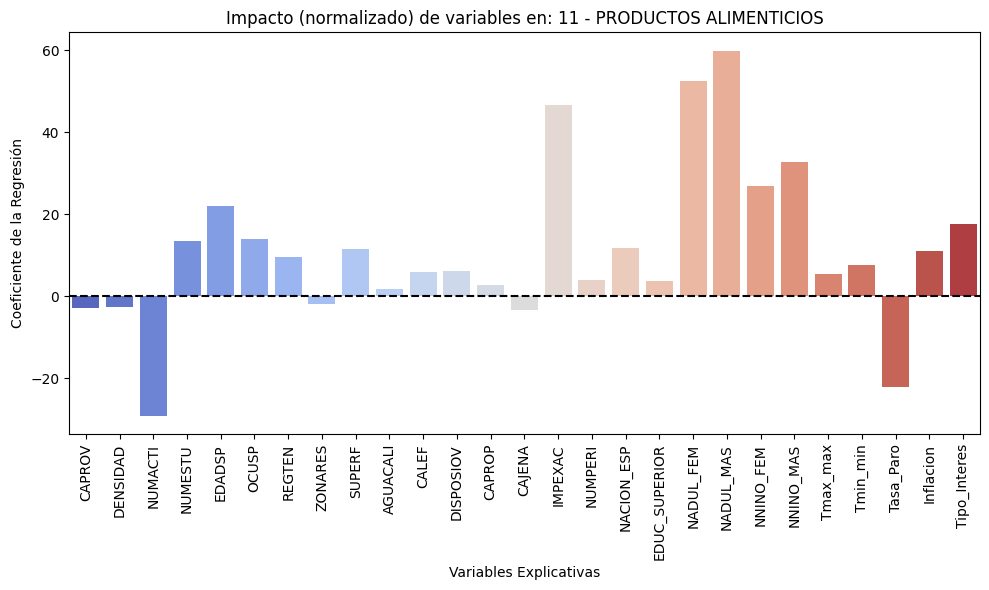

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


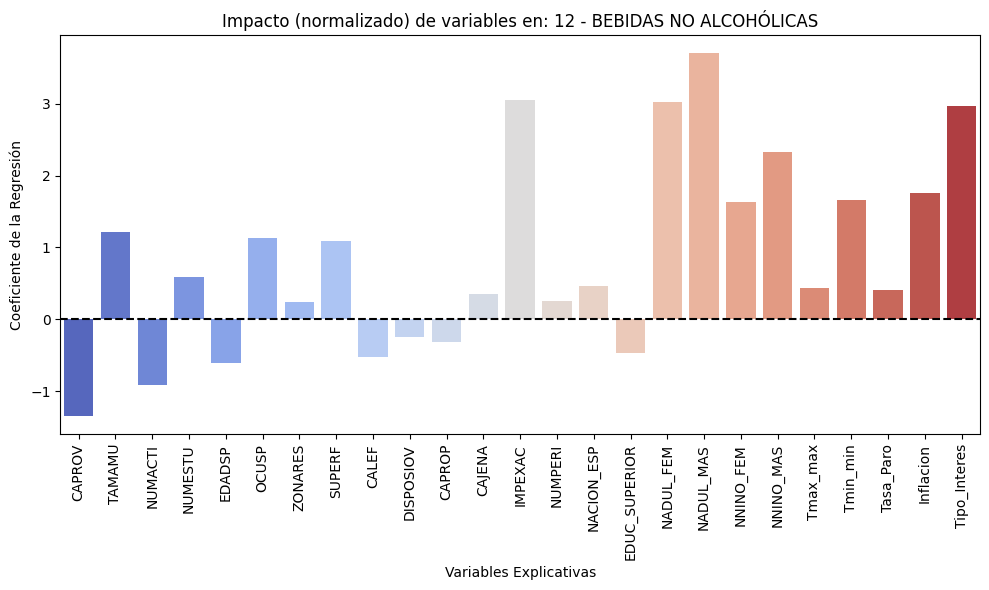

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


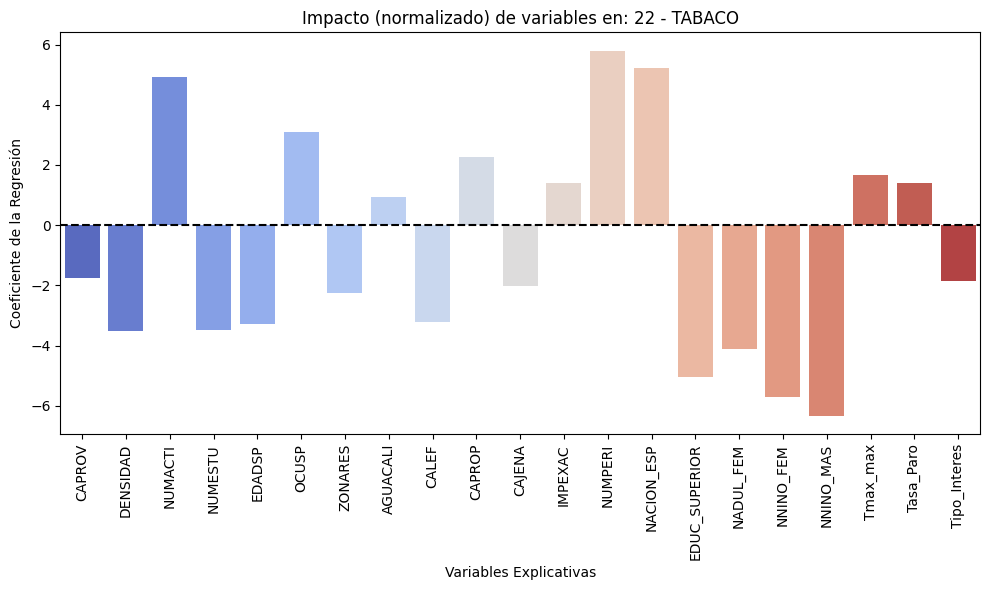

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


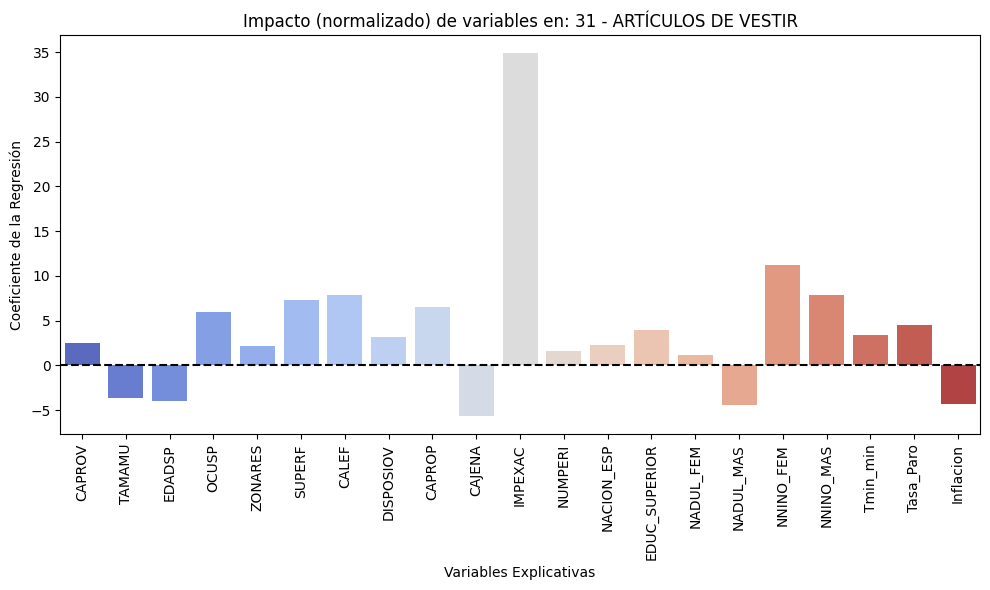

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


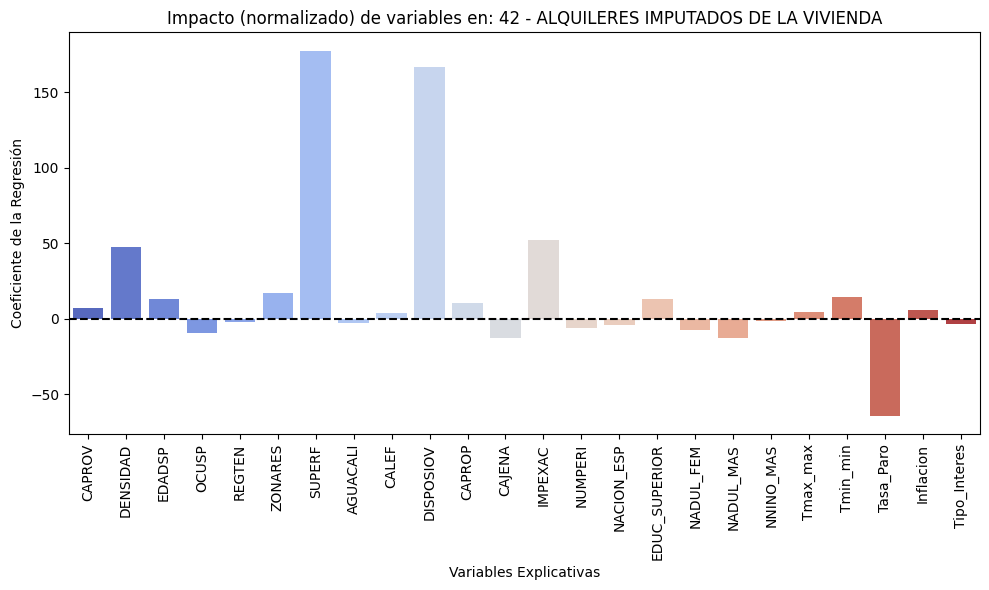

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


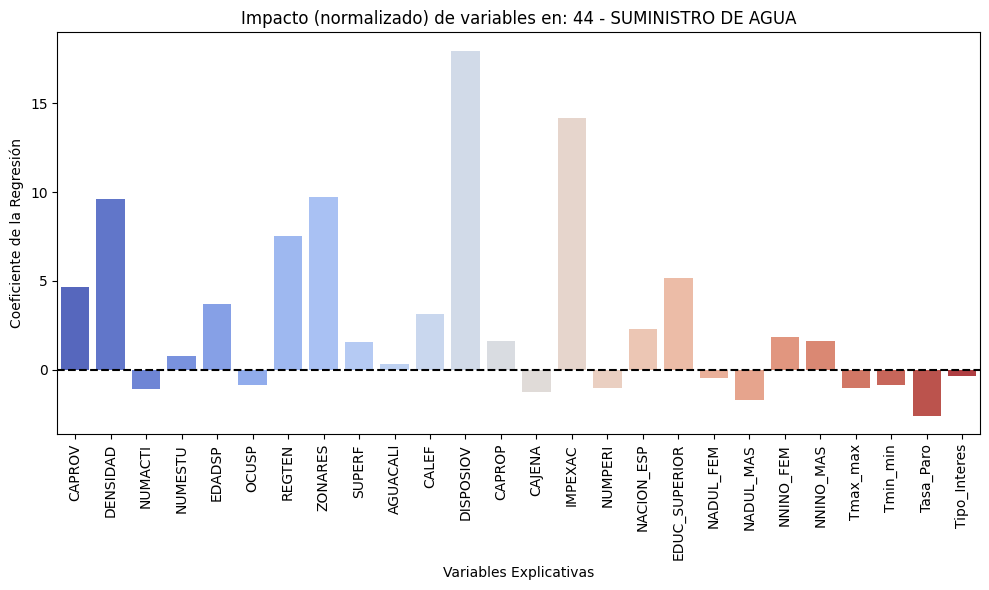

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


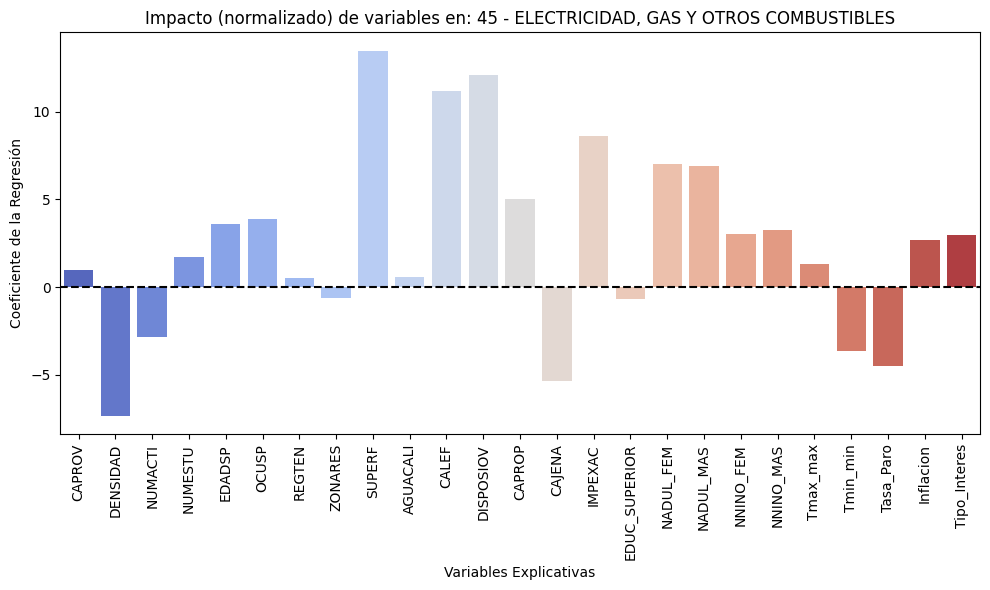

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


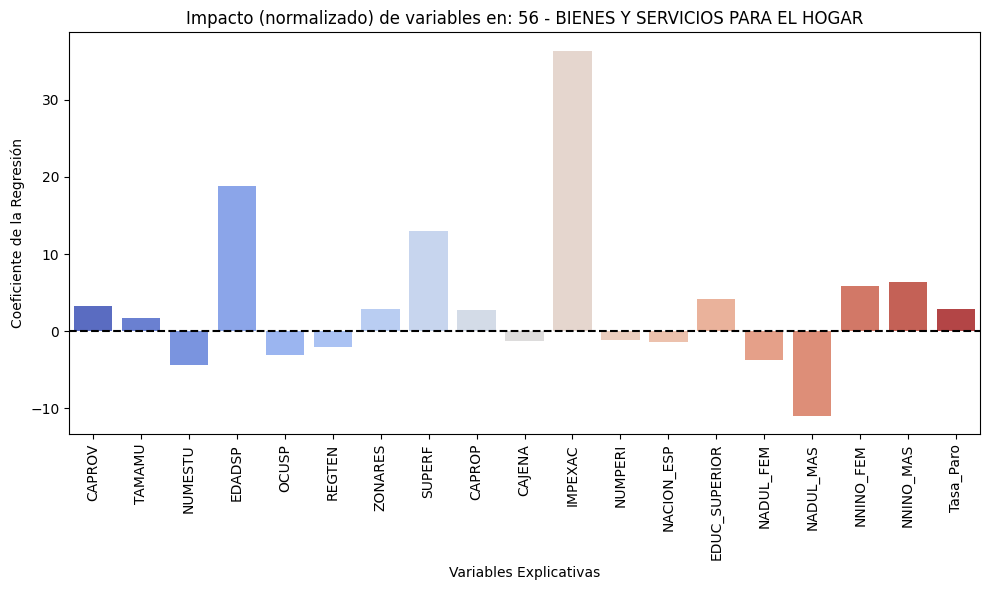

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


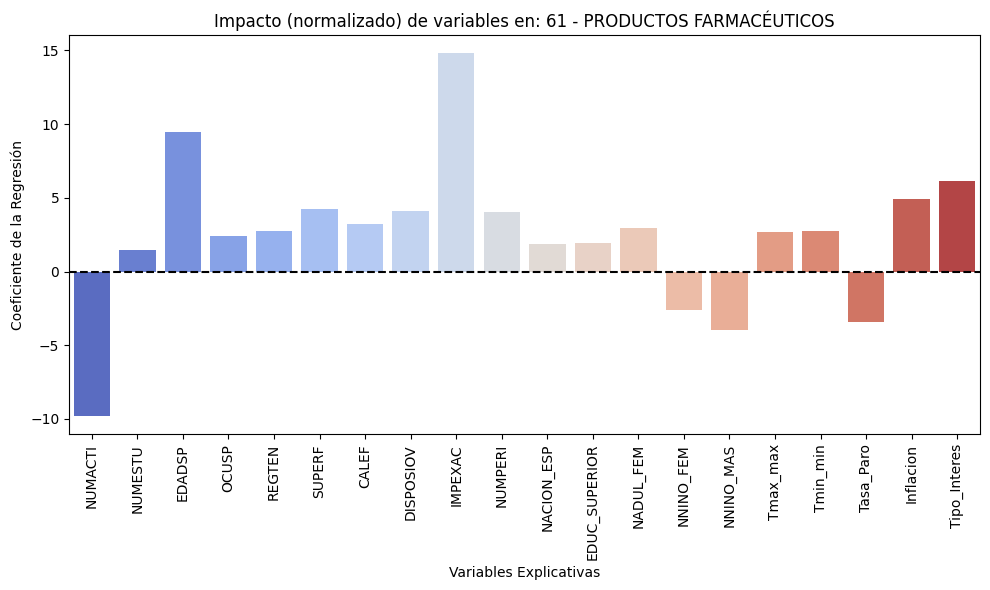

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


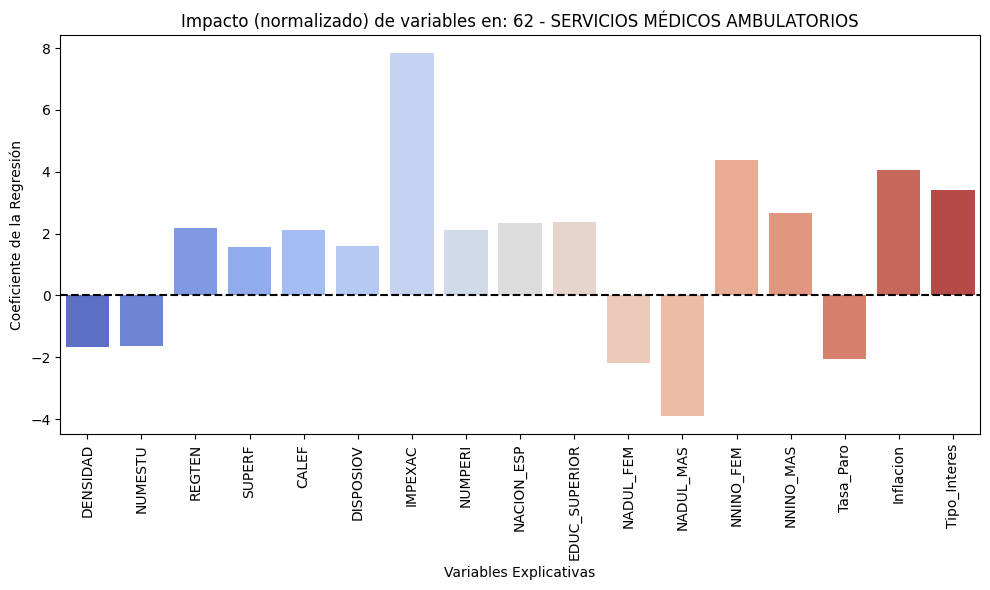

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


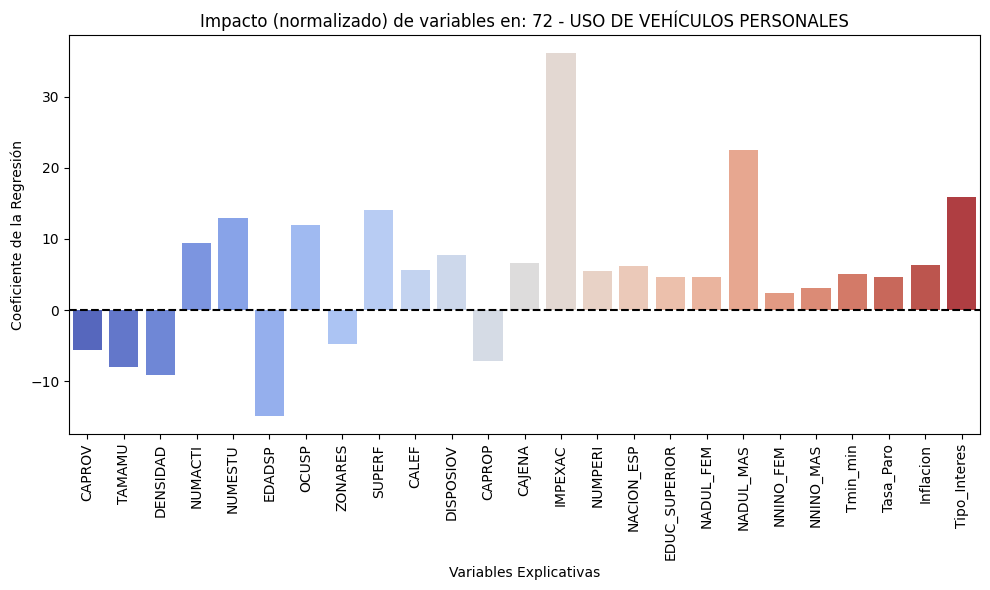

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


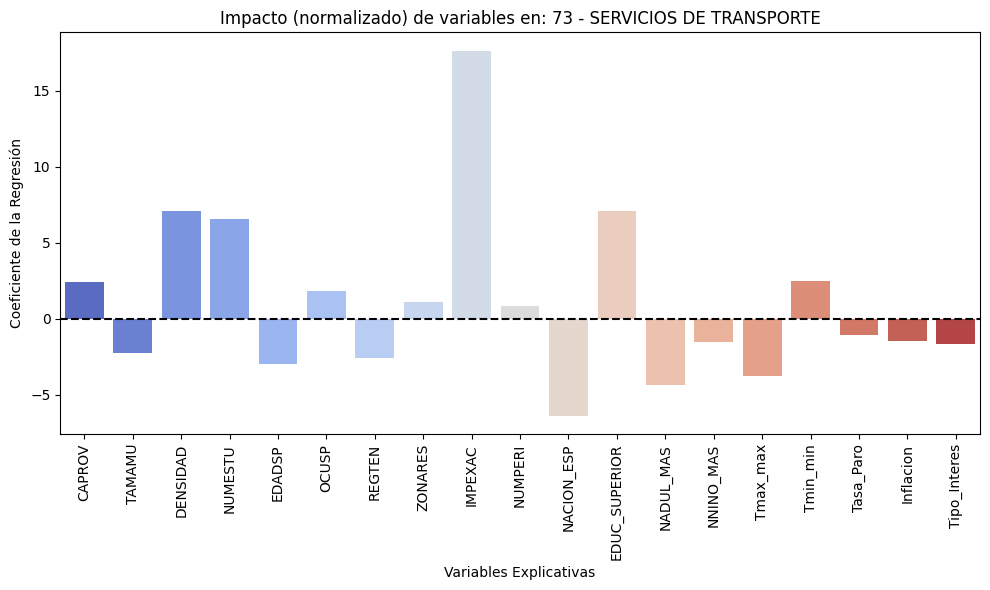

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


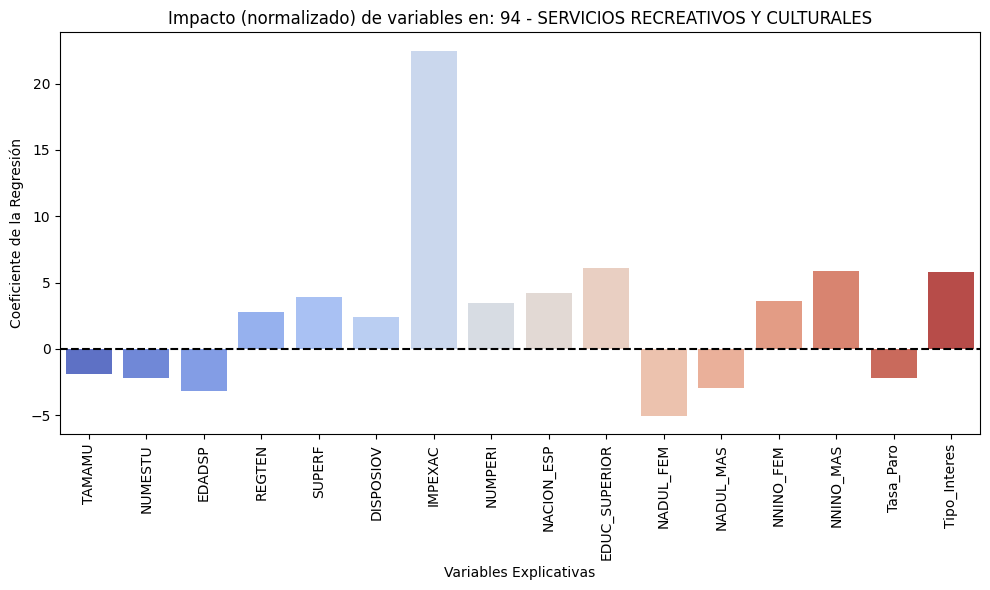

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


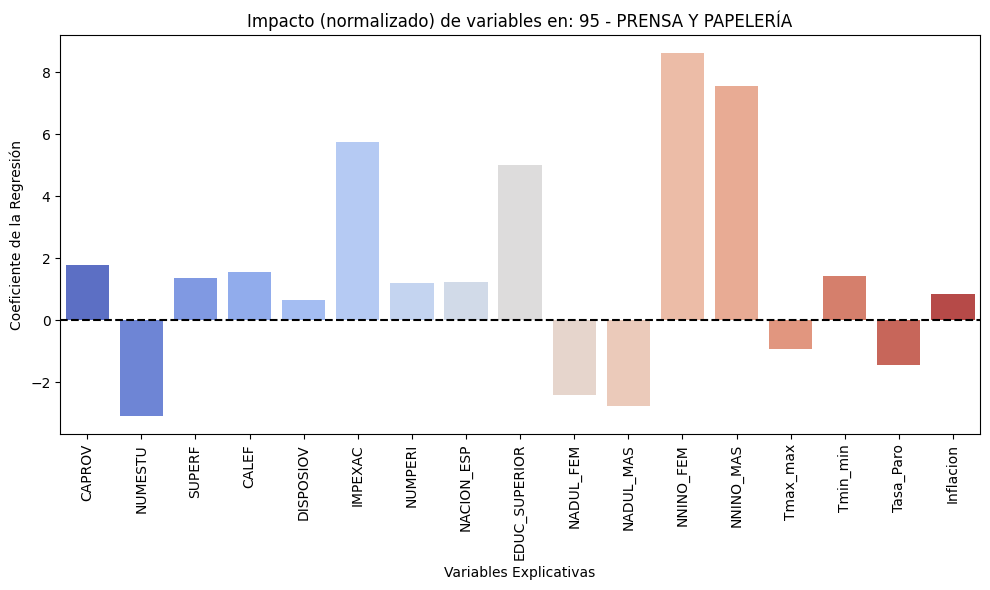

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


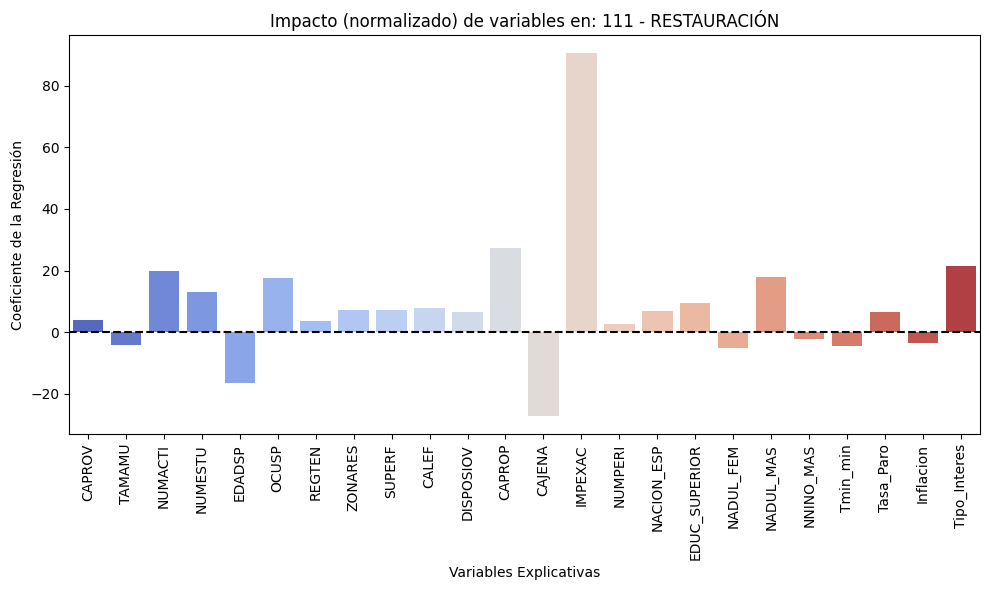

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


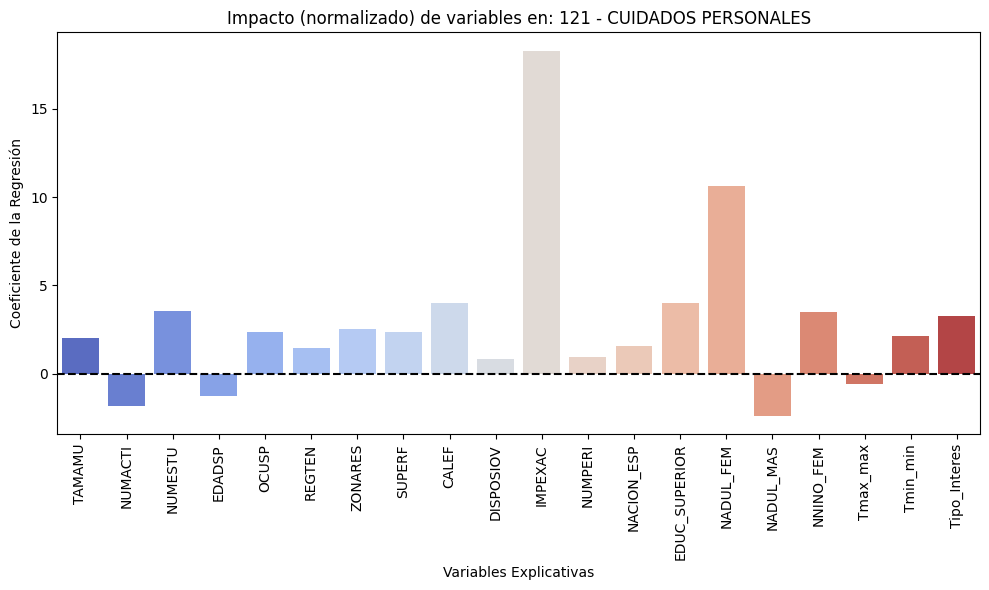

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


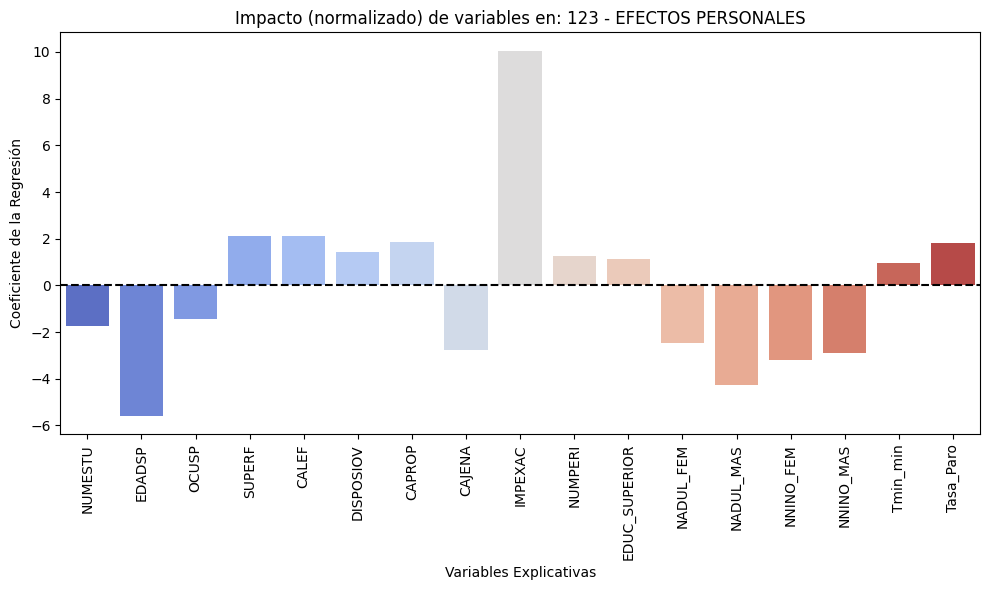

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


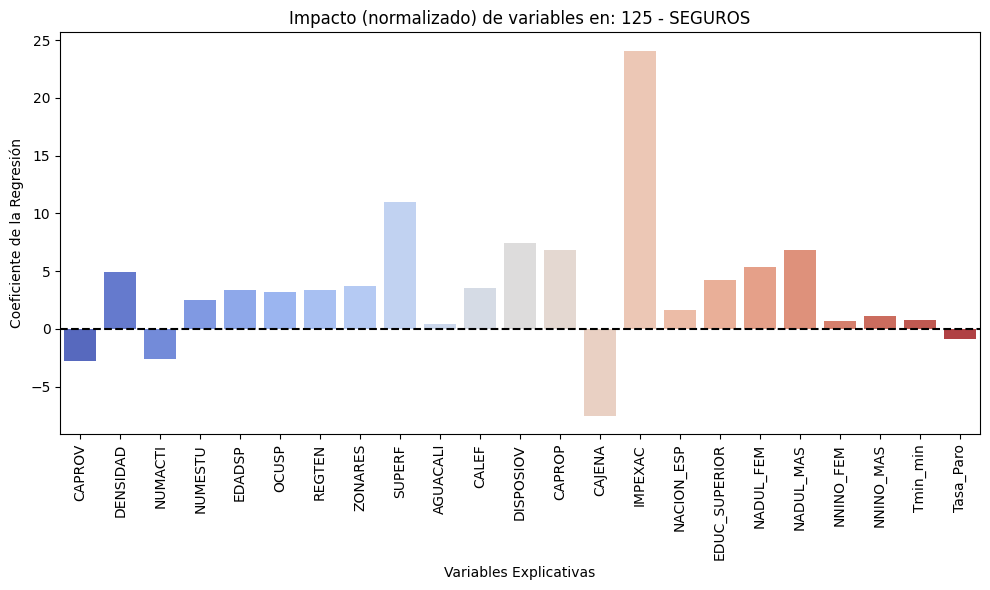

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


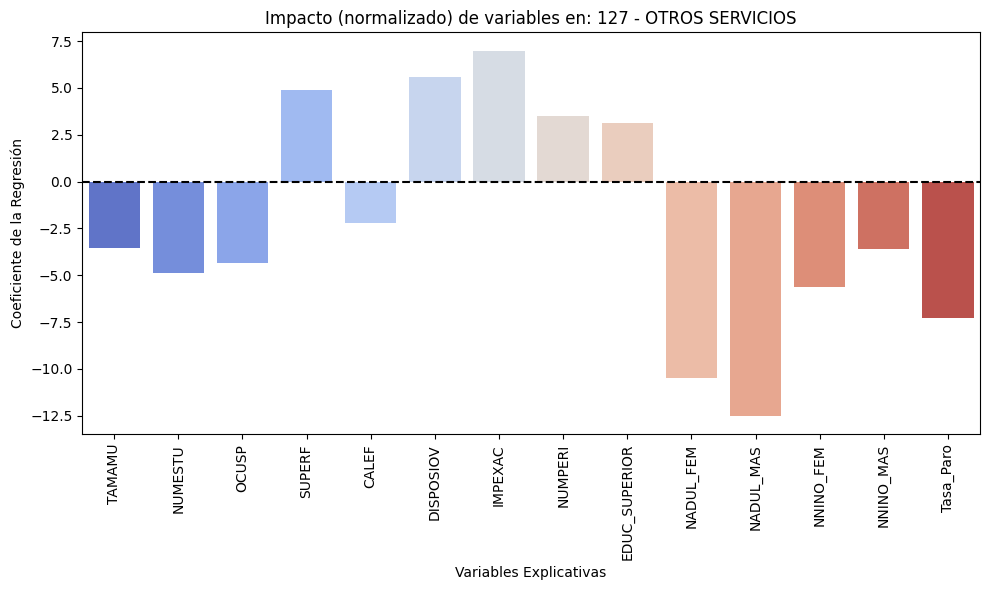

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


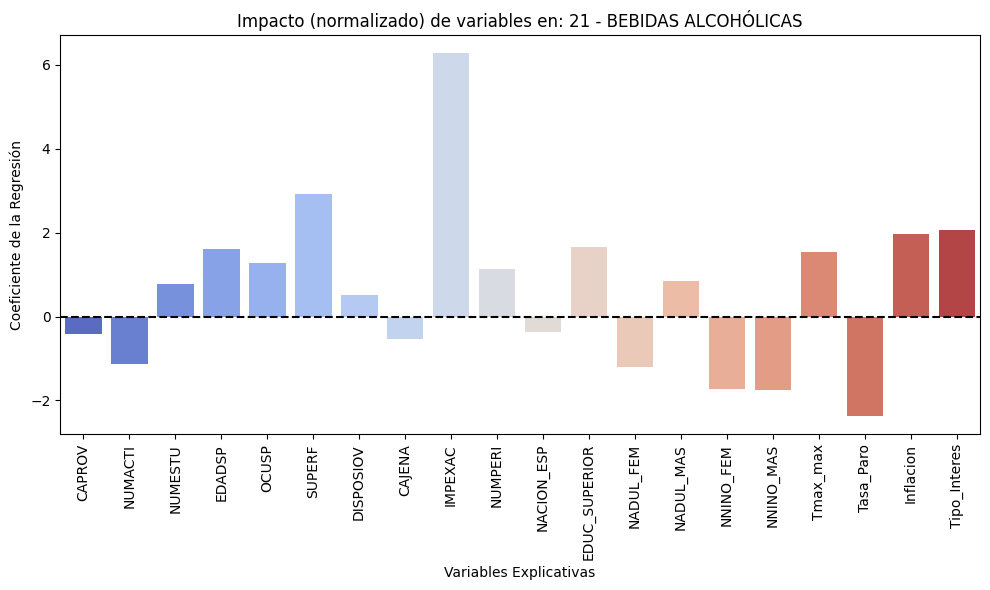

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


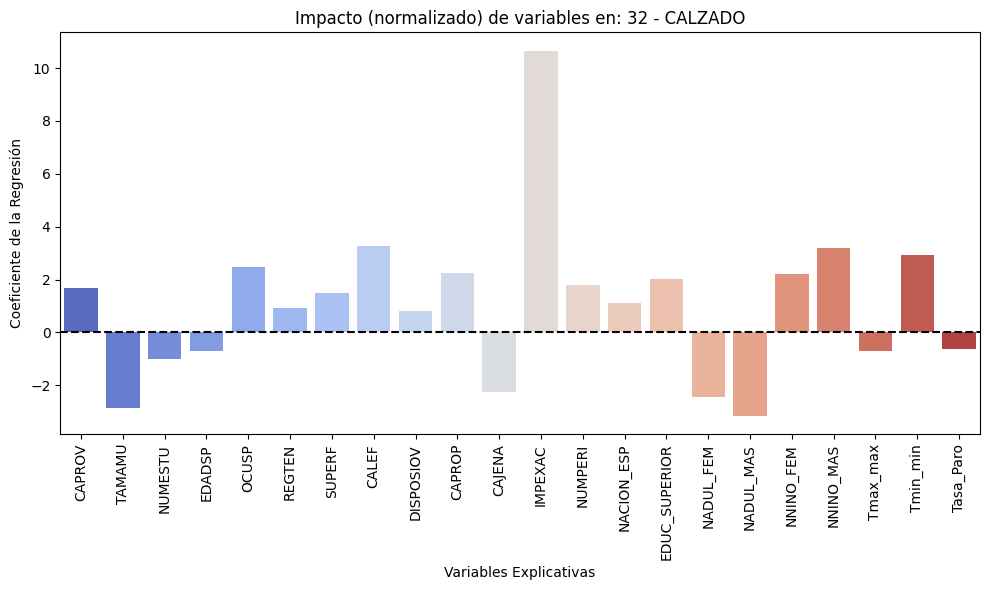

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


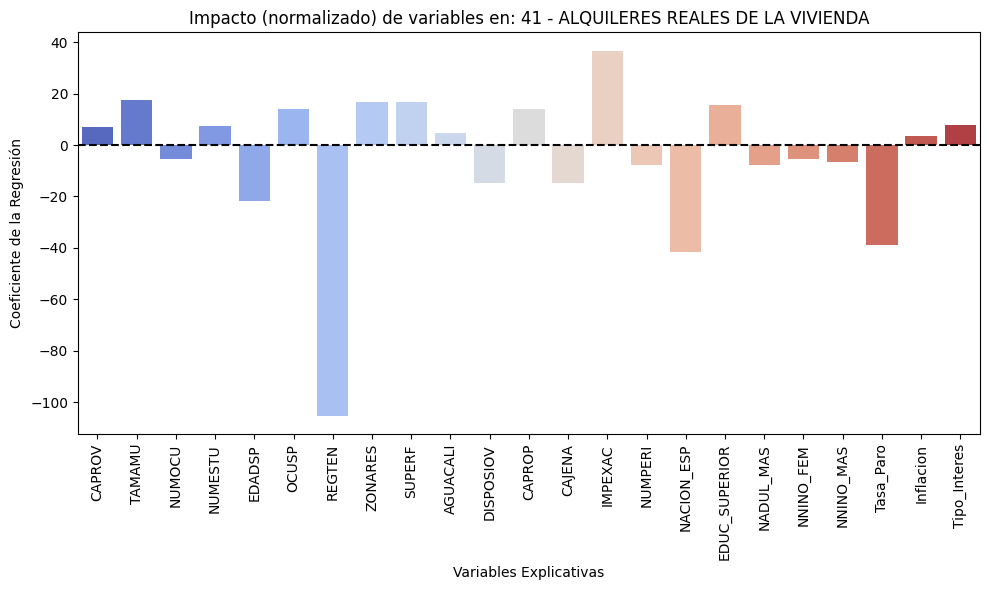

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


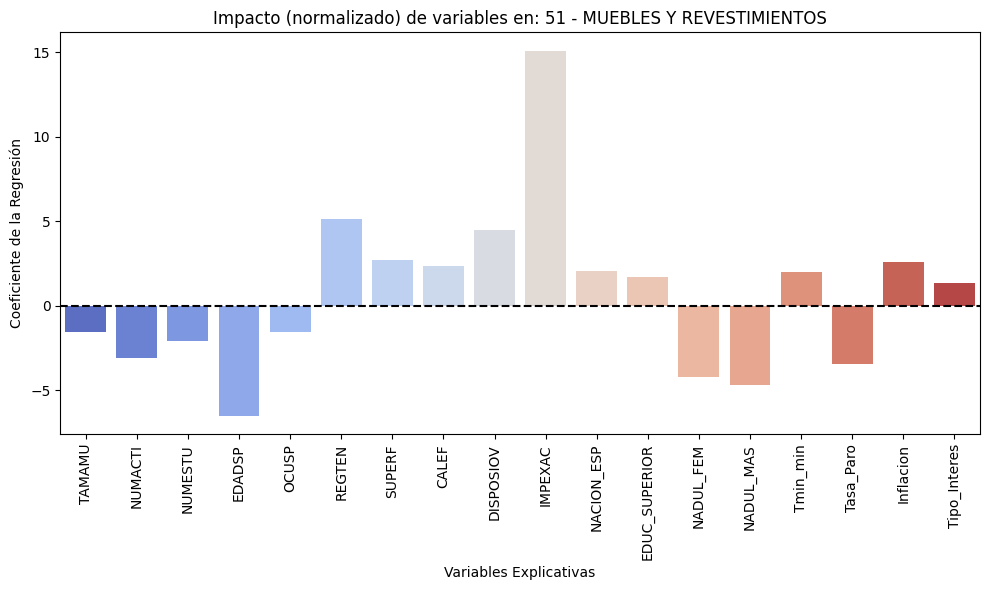

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


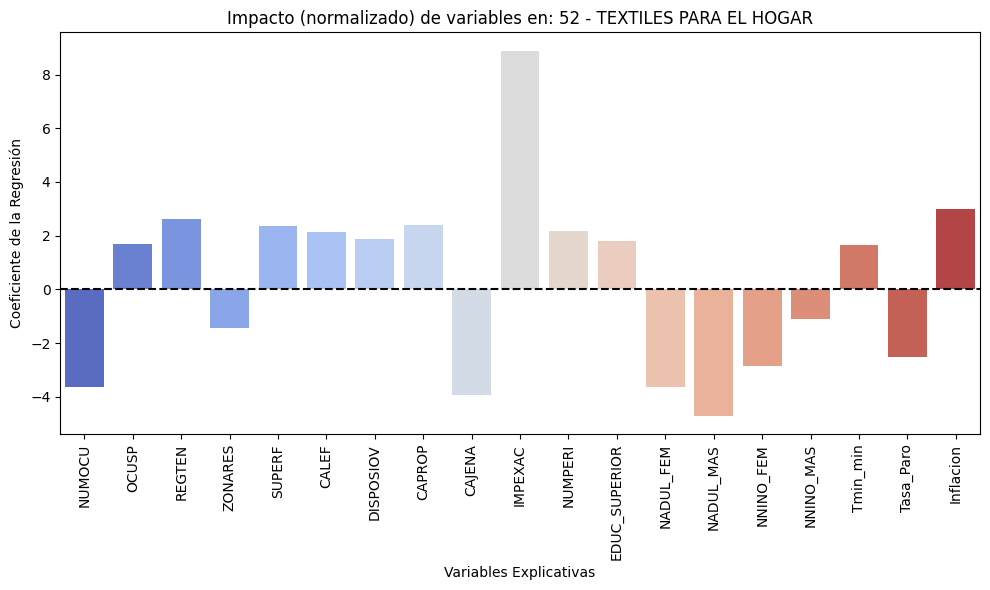

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


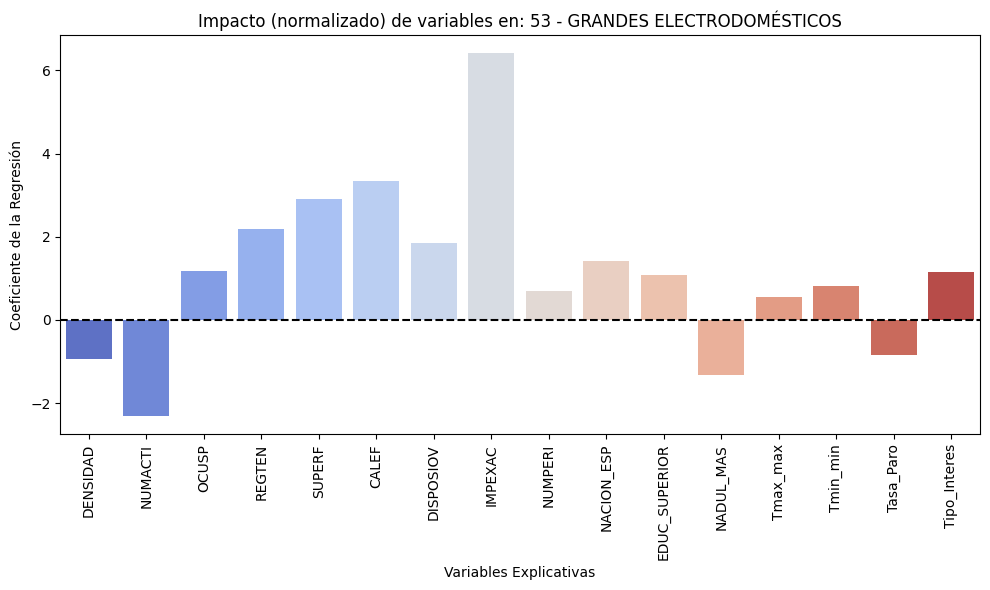

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


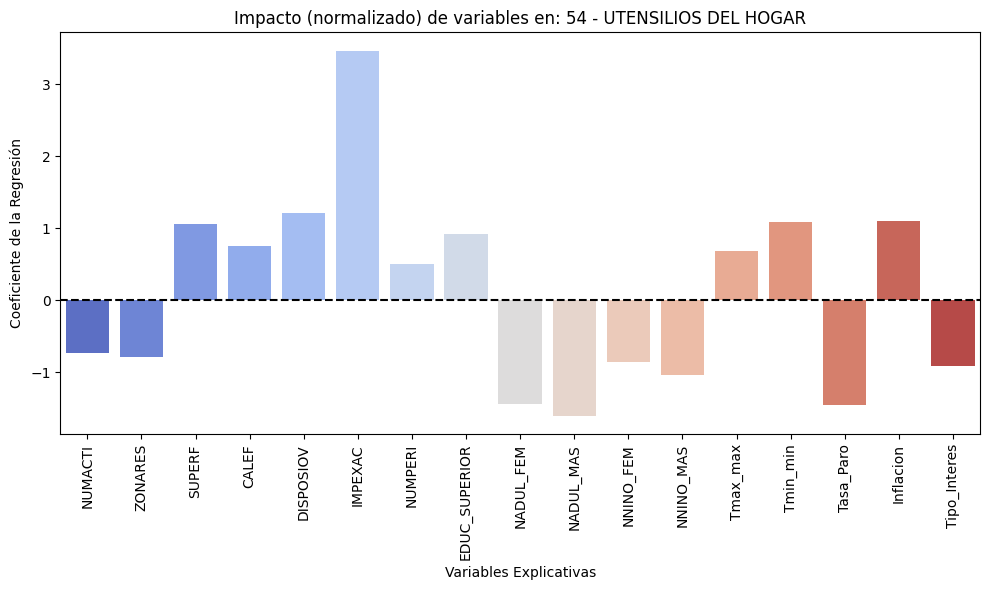

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


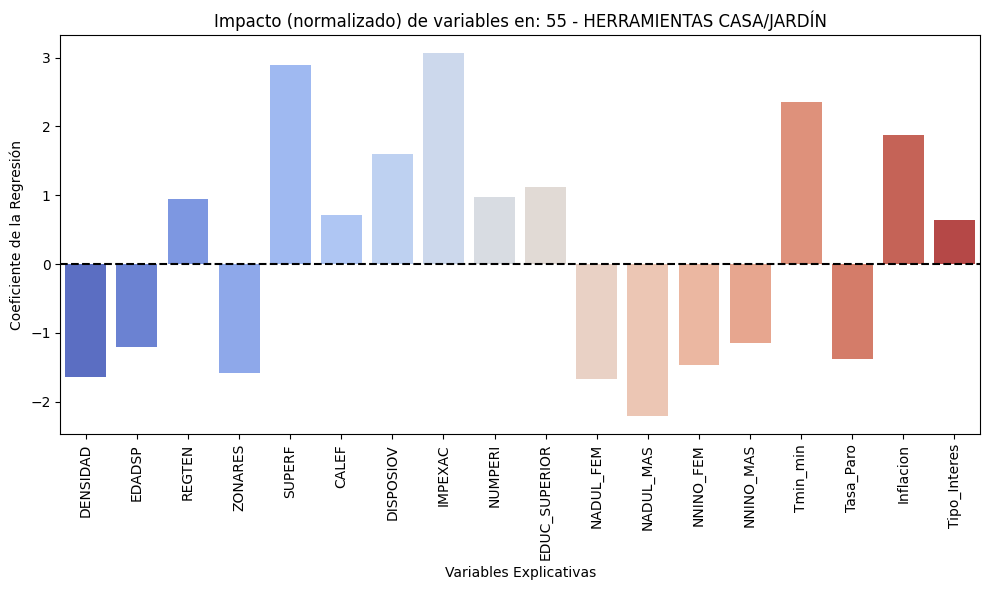

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


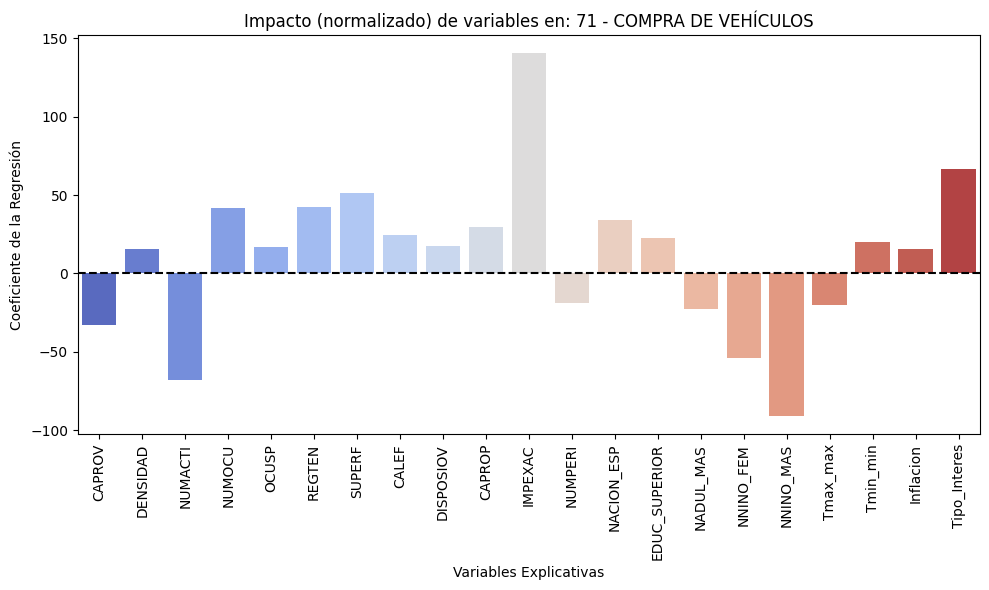

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


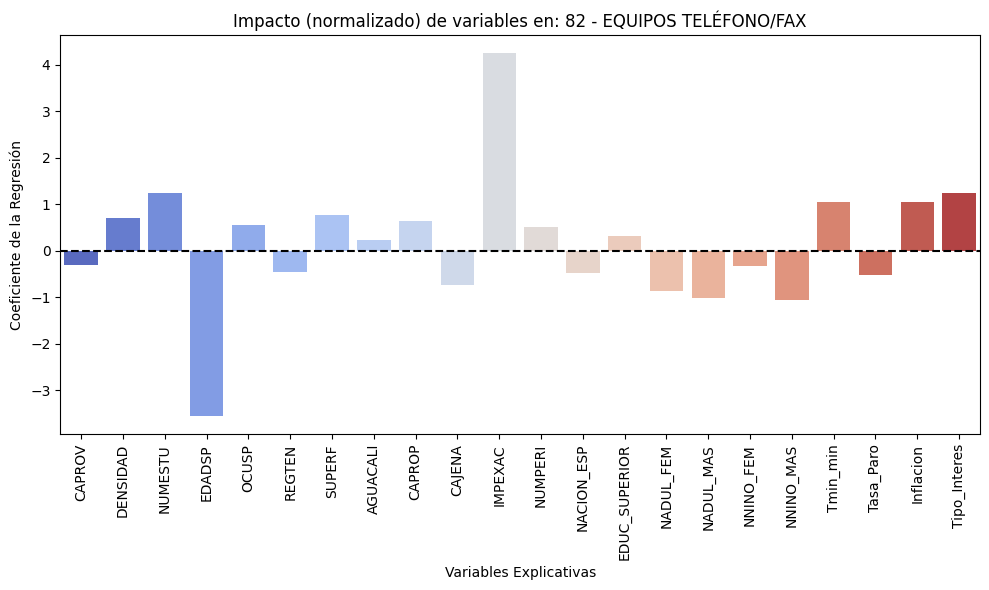

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


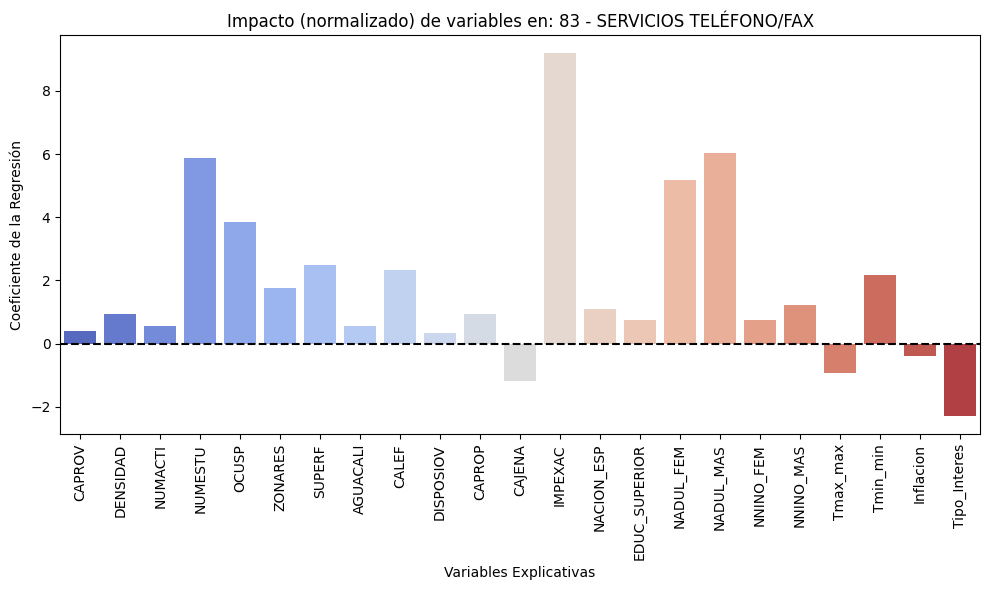

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


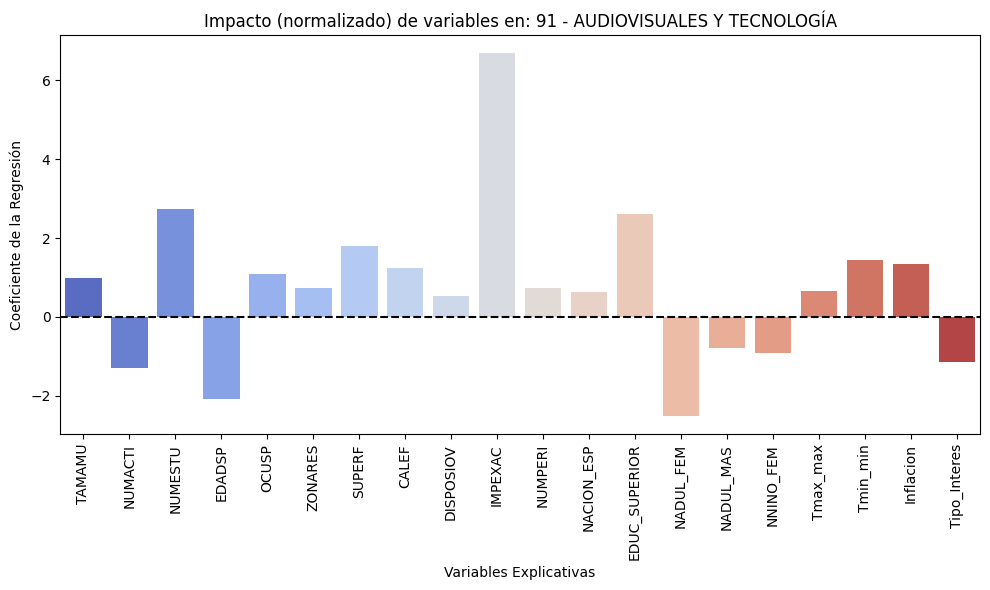

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


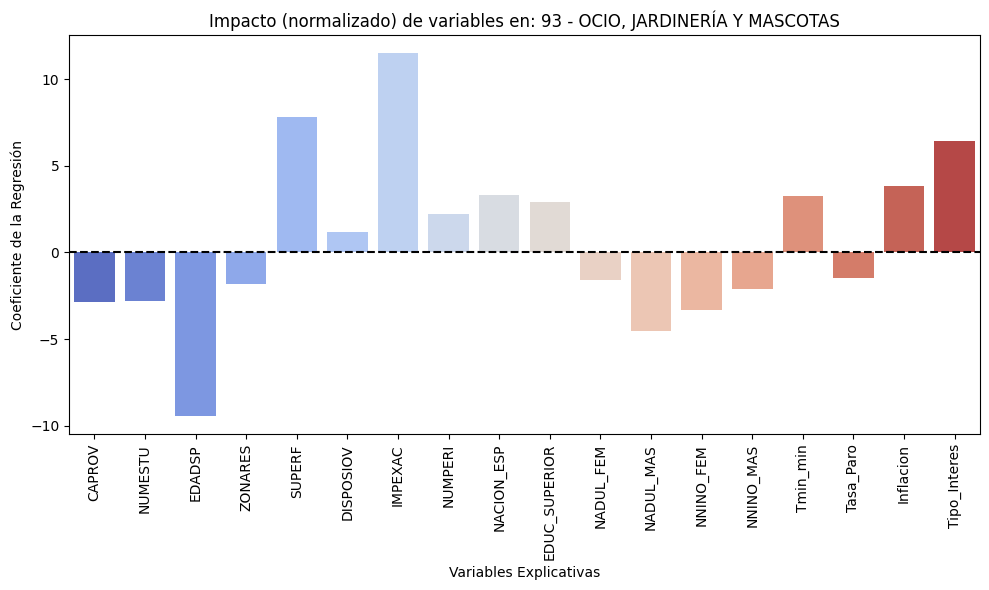

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


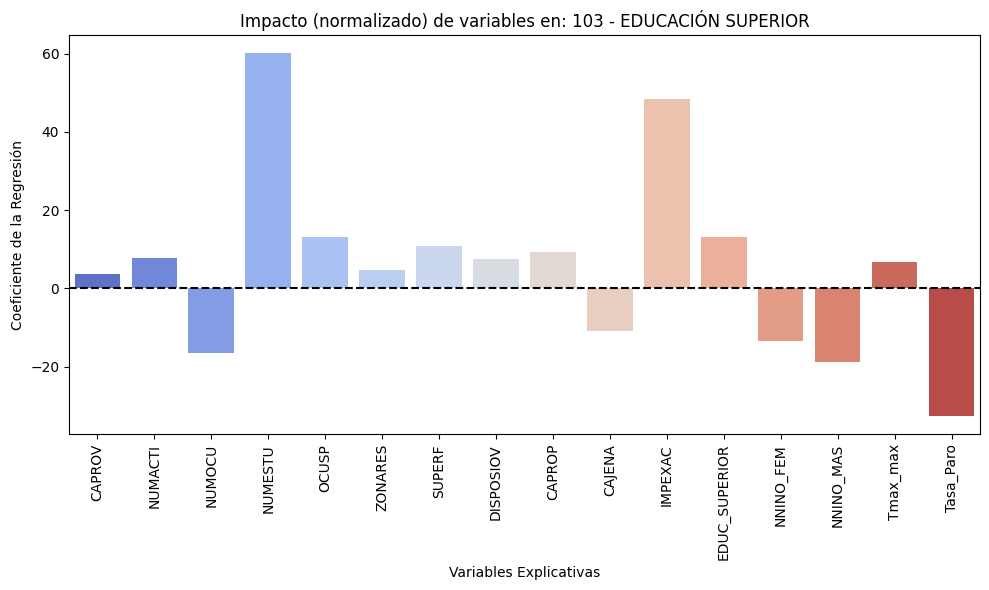

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


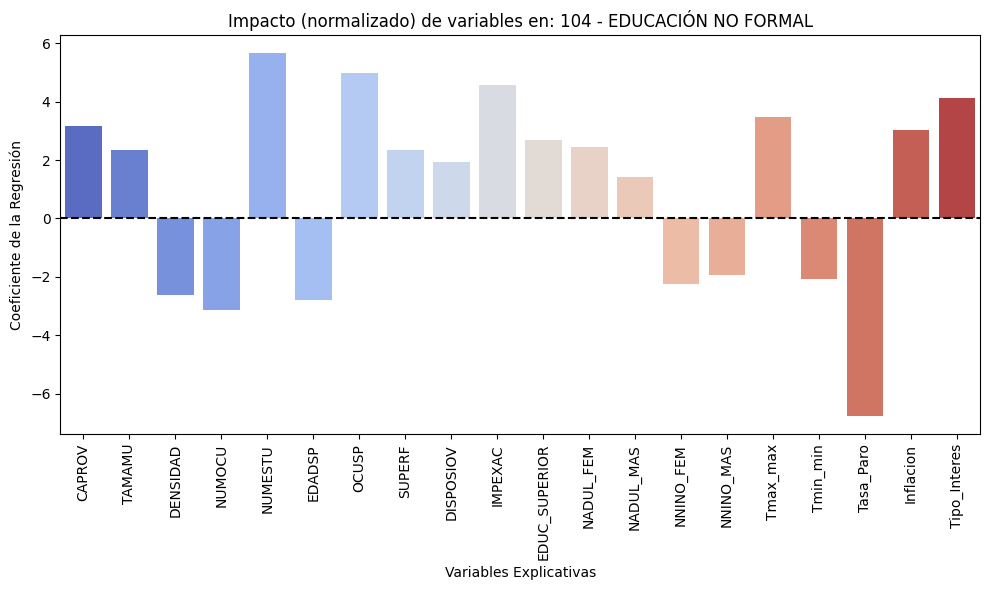

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


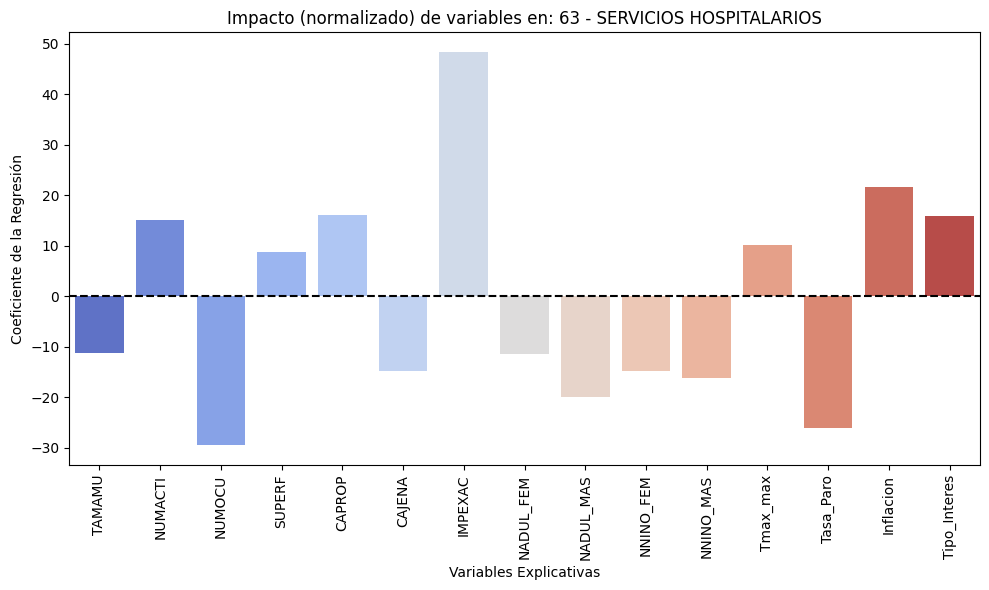

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


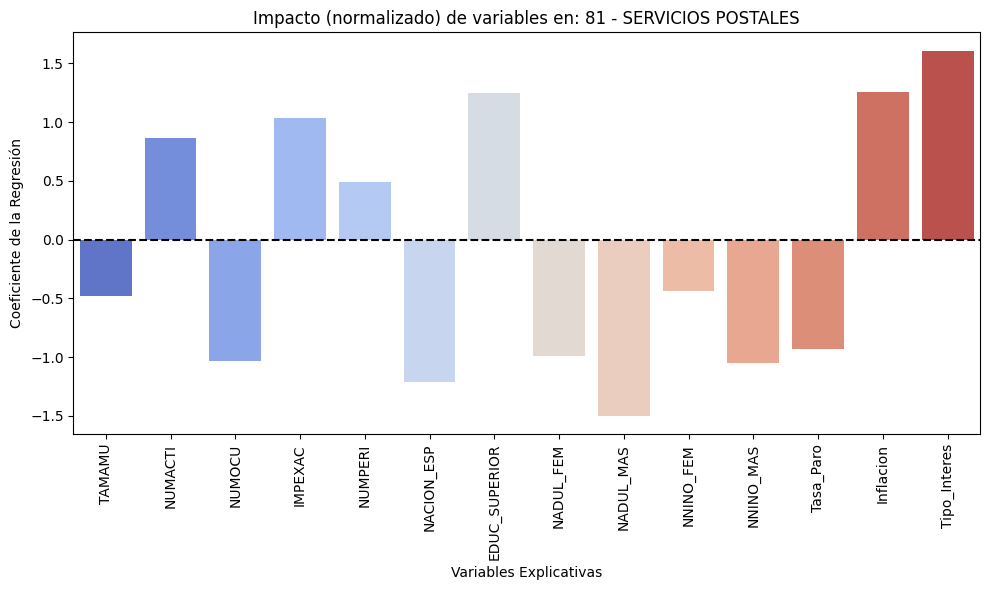

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


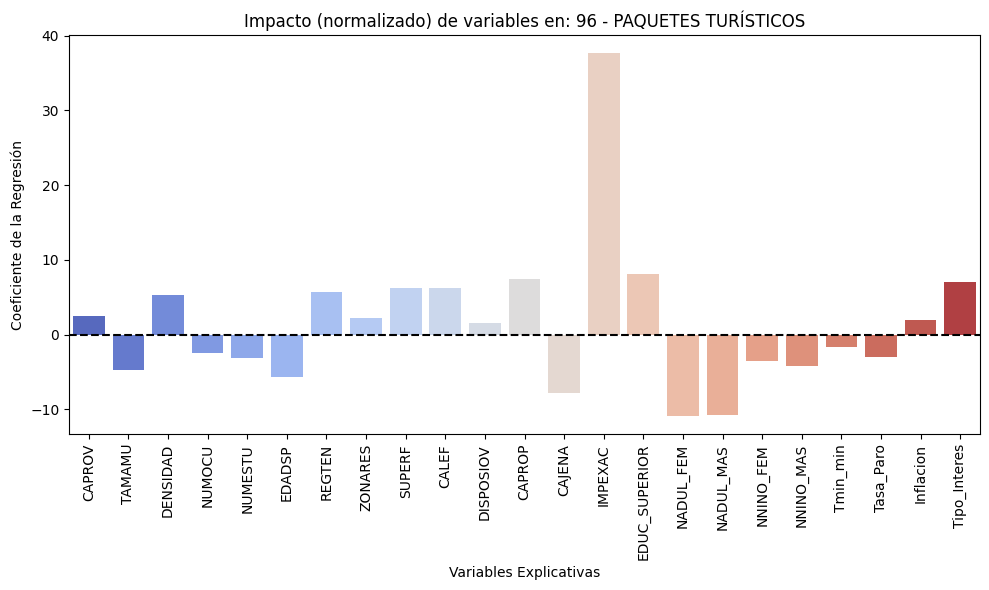

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


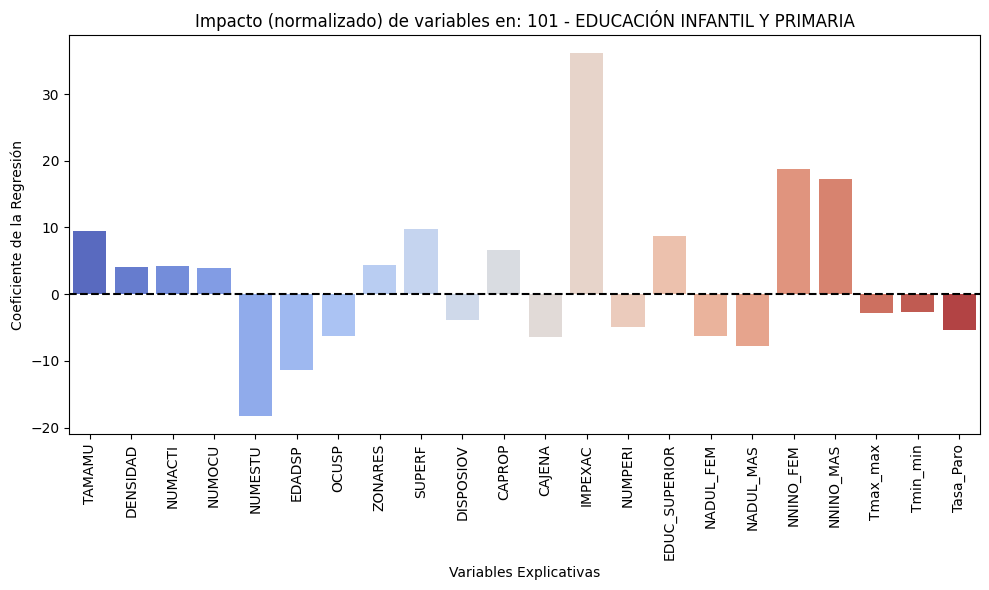

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


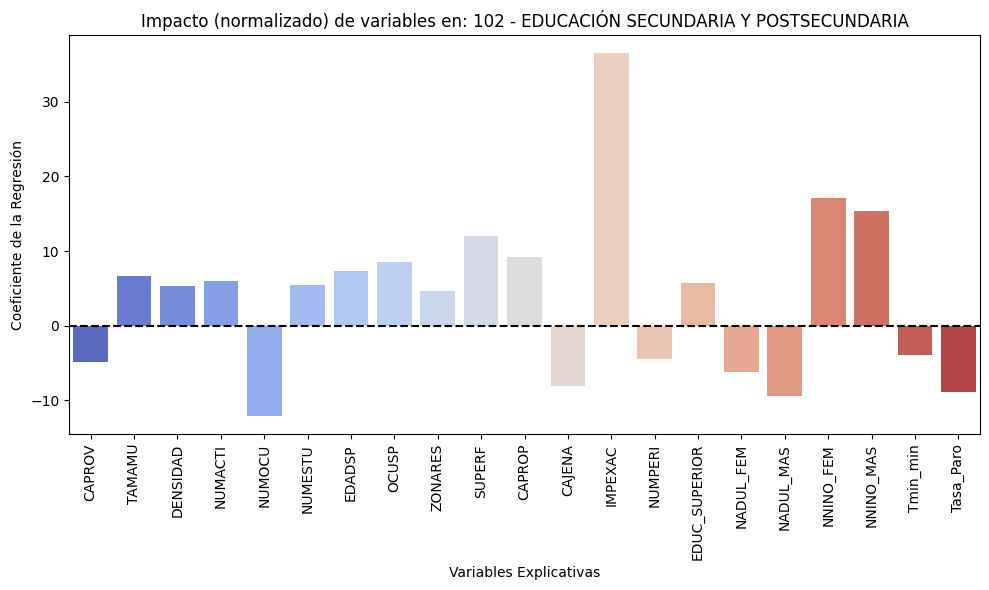

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


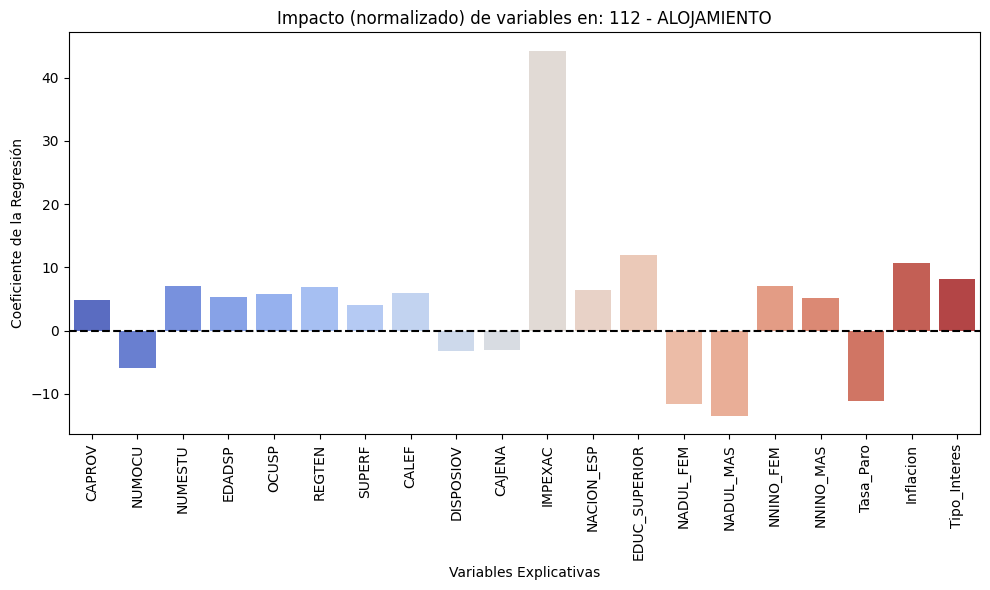

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


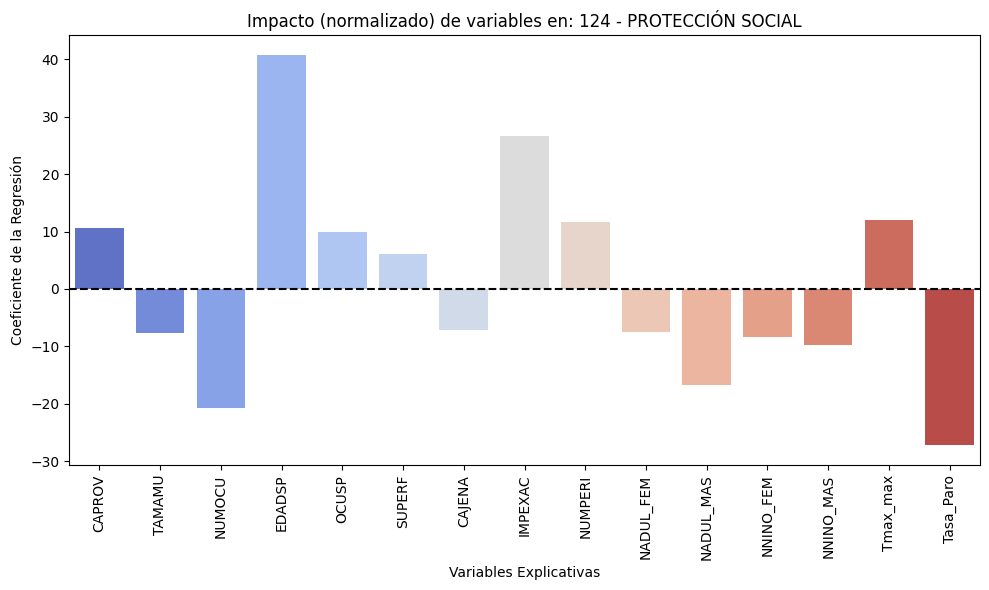

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


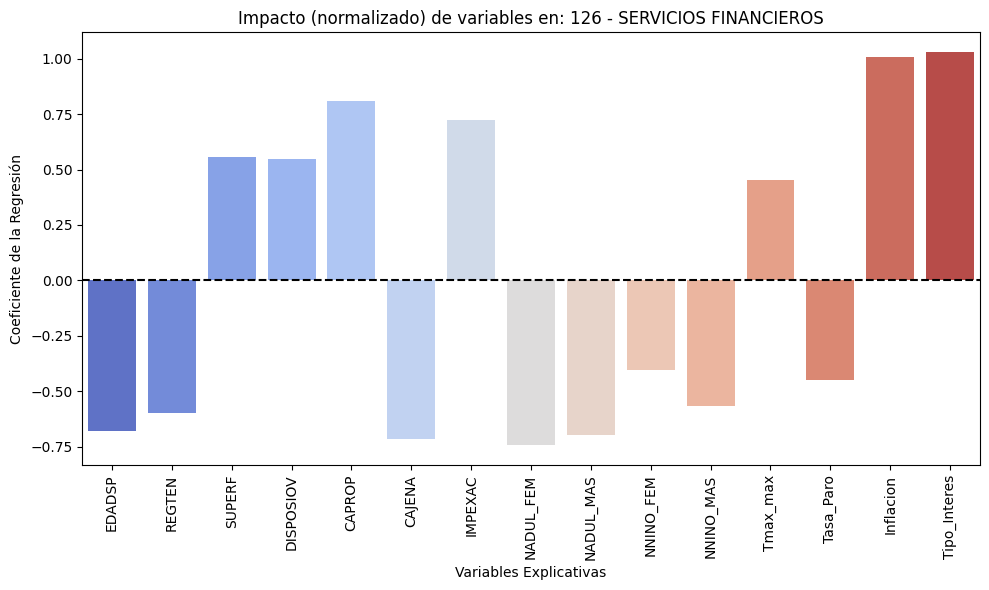

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


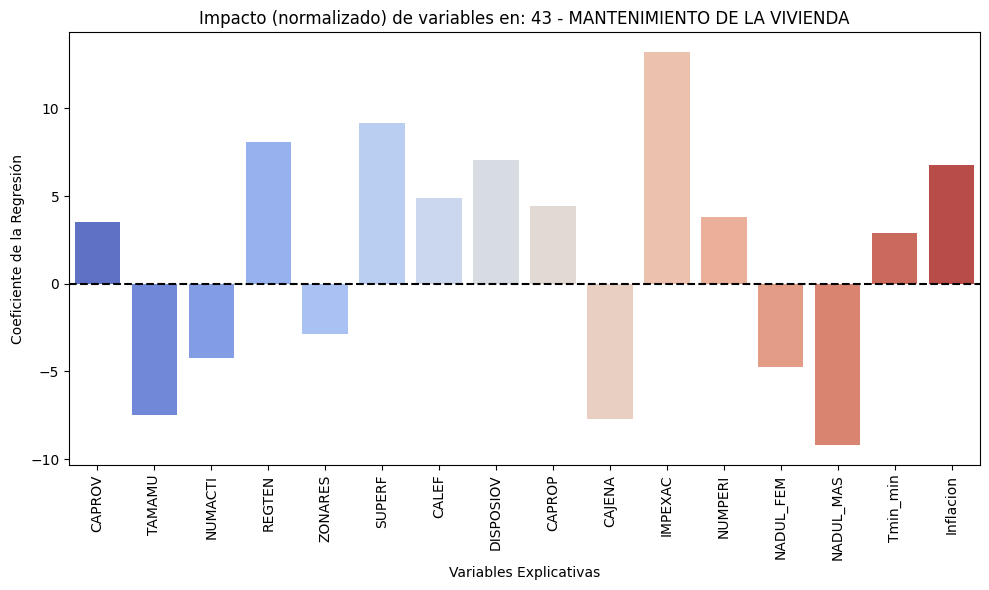

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


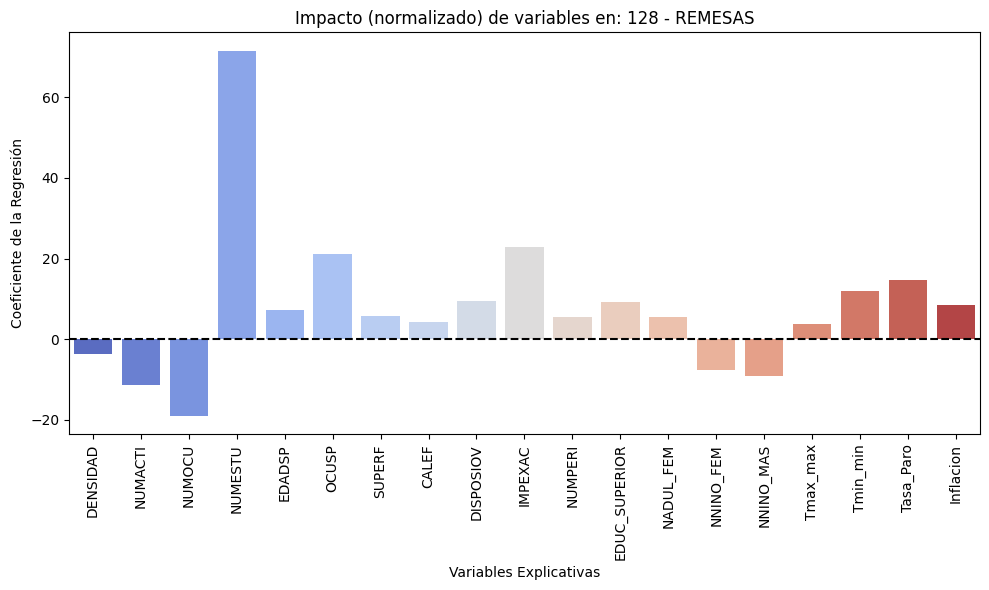

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3780942829.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="Variable", y="Coeficiente", palette="coolwarm")


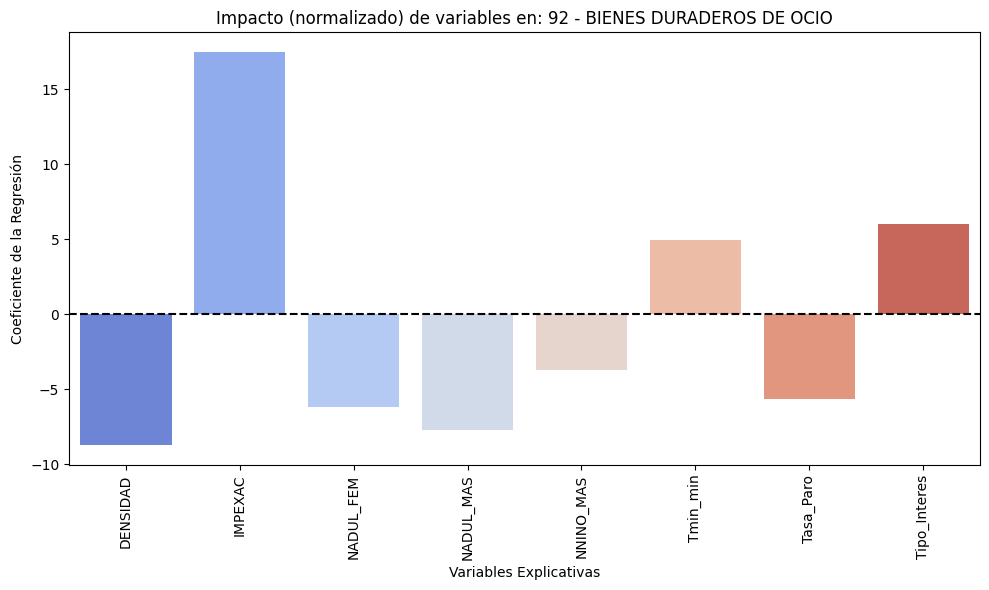

In [33]:
# Ejecutar regresión con variables normalizadas
regression_results, coefficients_df = run_regression_by_category_normalized(df_final)

# Eliminar la constante de la regresión
coefficients_df = coefficients_df[coefficients_df["Variable"] != "const"]

# Graficar los coeficientes más importantes por supercategoría
plot_coefficients_per_category(coefficients_df)

## 📐 Interpretación de un Modelo de Regresión Lineal Múltiple Normalizado

### 🔄 ¿Qué significa "normalizado"?

Cuando se normaliza un modelo, las variables se transforman para que tengan:

- **Media = 0**
- **Desviación estándar = 1**

Esta normalización se aplica a las variables explicativas (X), y opcionalmente también a la variable dependiente (y).

---

### 🎯 ¿Cómo se interpretan los coeficientes?

En un modelo normalizado, **los coeficientes se interpretan en términos de desviaciones estándar**:

> Un coeficiente indica cuántas desviaciones estándar cambia la variable dependiente por cada desviación estándar de cambio en la variable independiente, manteniendo las demás constantes.

---

### 💡 Ejemplo de interpretación

- Si el coeficiente de `IMPEXAC` es **+1.2**:
  - Entonces, **un aumento de 1 desviación estándar en los ingresos (`IMPEXAC`)** se asocia con un aumento de **1.2 desviaciones estándar en el gasto mensual**.

- Si el coeficiente de `NUMESTU` es **-0.5**:
  - Entonces, **un aumento de 1 desviación estándar en el número de estudiantes** se asocia con una **disminución de 0.5 desviaciones estándar en el gasto mensual**.

---

### ✅ Ventajas de la normalización

- Permite **comparar directamente el peso relativo de cada variable** en el modelo.
- Evita que variables con escalas más grandes dominen el modelo por su magnitud.
- Es útil en modelos con muchas variables heterogéneas (e.g. edad, ingresos, tamaño del hogar, etc.).

---

### ⚠️ Consideraciones

- Los coeficientes ya no están en unidades interpretables (euros, años, personas...).
- Solo tiene sentido si se desea analizar **la importancia relativa** de las variables, no el efecto real en magnitudes absolutas.


### Obtenemos los coeficientes reales y vemos en que categorías impacta más cada variable y cuánto

In [34]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def run_regression_by_category(df, target_variable="GASTO_MENSUAL"):
    """
    Ejecuta una regresión lineal múltiple para cada supercategoría y devuelve los coeficientes y p-valores.
    """
    results = {}
    coefficients = []

    # Variables explicativas (excluimos Año, NUMERO, SUPER_CATEGORIA y CCAA)
    independent_vars = df.select_dtypes(include=["number"]).columns.tolist()
    independent_vars = [var for var in independent_vars if var not in ["Año", "NUMERO", "GASTO_MENSUAL", "CCAA", "SUPER_CATEGORIA", "FACTOR", "NACION_EXT", "GASTOT"]]

    for category in df["SUPER_CATEGORIA"].unique():
        df_category = df[df["SUPER_CATEGORIA"] == category].dropna()

        if len(df_category) < len(independent_vars):  # Evitar problemas con pocas observaciones
            continue

        X = df_category[independent_vars]  # Variables independientes
        y = df_category[target_variable]  # Variable dependiente

        X = sm.add_constant(X)  # Agregar intercepto
        model = sm.OLS(y, X).fit()  # Ajustar modelo

        results[category] = model

        # Guardar coeficientes y p-valores para graficar
        coef_df = pd.DataFrame({
            "Variable": model.params.index,
            "Coeficiente": model.params.values,
            "P-Valor": model.pvalues.values,
            "Super_Categoria": category
        })

        # Filtrar variables significativas (p-valor < 0.05)
        coef_df = coef_df[coef_df["P-Valor"] < 0.05]

        coefficients.append(coef_df)

    coefficients_df = pd.concat(coefficients, ignore_index=True)
    return results, coefficients_df

# Ejecutar la regresión por supercategoría
regression_results, coefficients_df = run_regression_by_category(df_final)




In [35]:
# Mostrar coeficientes de IMPEXAC Y ORDENALOS POR COEFICIENTE
coefficients_df[coefficients_df["Variable"] == "IMPEXAC"].sort_values(by="Coeficiente", ascending=False)

Variable  Coeficiente        P-Valor  Super_Categoria
585  IMPEXAC     0.092098   2.996568e-81               71
332  IMPEXAC     0.057579   0.000000e+00              111
113  IMPEXAC     0.039312   0.000000e+00               42
725  IMPEXAC     0.032525   4.119192e-28               63
16   IMPEXAC     0.032205   0.000000e+00               11
693  IMPEXAC     0.028206  1.510417e-105              103
826  IMPEXAC     0.027147  9.365776e-294              112
189  IMPEXAC     0.026429   0.000000e+00               56
482  IMPEXAC     0.025211  1.621491e-112               41
761  IMPEXAC     0.024326   0.000000e+00               96
784  IMPEXAC     0.023316  1.947598e-276              101
88   IMPEXAC     0.022956   0.000000e+00               31
807  IMPEXAC     0.022766  1.151211e-247              102
251  IMPEXAC     0.022278  3.254354e-194               72
842  IMPEXAC     0.016902   1.725888e-17              124
398  IMPEXAC     0.016754   0.000000e+00              125
291  IMPEXAC     0.014194  1.913922e-128               94
889  IMPEXAC     0.013834   4.331845e-26              128
353  IMPEXAC     0.012332   0.000000e+00              121
274  IMPEXAC     0.011042  7.535922e-237               73
901  IMPEXAC     0.010696   1.797610e-13               92
142  IMPEXAC     0.010678   0.000000e+00               44
206  IMPEXAC     0.009898   1.533959e-85               61
501  IMPEXAC     0.009843  7.699924e-128               51
874  IMPEXAC     0.007989   2.128807e-17               43
672  IMPEXAC     0.007074   6.600986e-57               93
457  IMPEXAC     0.006830  8.572864e-252               32
632  IMPEXAC     0.006516   0.000000e+00               83
372  IMPEXAC     0.006452   3.998632e-73              123
167  IMPEXAC     0.006103   0.000000e+00               45
519  IMPEXAC     0.005829   1.763403e-40               52
225  IMPEXAC     0.004893   1.681987e-21               62
414  IMPEXAC     0.004657   8.935371e-09              127
431  IMPEXAC     0.004464  3.318884e-166               21
533  IMPEXAC     0.004380   4.474097e-93               53
652  IMPEXAC     0.004314  5.714086e-114               91
307  IMPEXAC     0.003552   1.494672e-62               95
708  IMPEXAC     0.002828   2.569899e-10              104
608  IMPEXAC     0.002759  1.661550e-189               82
548  IMPEXAC     0.002342   7.293993e-34               54
41   IMPEXAC     0.002138  9.269158e-139               12
566  IMPEXAC     0.002042   6.503897e-17               55
65   IMPEXAC     0.001065   1.274885e-02               22
738  IMPEXAC     0.000657   1.156327e-04               81
856  IMPEXAC     0.000591   5.354933e-04              126

In [36]:
def plot_variable_impact_across_categories(coefficients_df):
    """
    Genera un gráfico por cada variable significativa mostrando su coeficiente
    en cada Super_Categoria.
    """
    variables = coefficients_df["Variable"].unique()

    for var in variables:
        # Filtrar el DataFrame para la variable actual
        df_var = coefficients_df[coefficients_df["Variable"] == var].copy()

        # Asegurar tipo string para categorías
        df_var["Super_Categoria"] = df_var["Super_Categoria"].astype(str)

        # Ordenar por coeficiente
        df_var = df_var.sort_values(by="Coeficiente", ascending=False)

        # Gráfico
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")
        plt.axhline(0, color="black", linestyle="--")
        plt.title(f"Impacto de {var} en el gasto mensual por categoría")
        plt.xlabel("Super Categoría")
        plt.ylabel(f"Coeficiente de {var}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


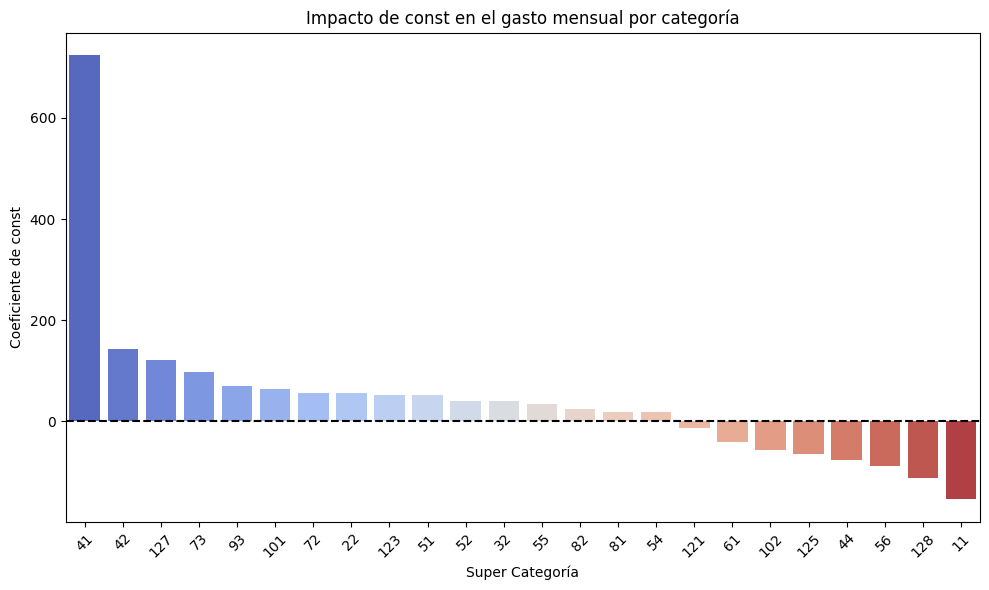

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


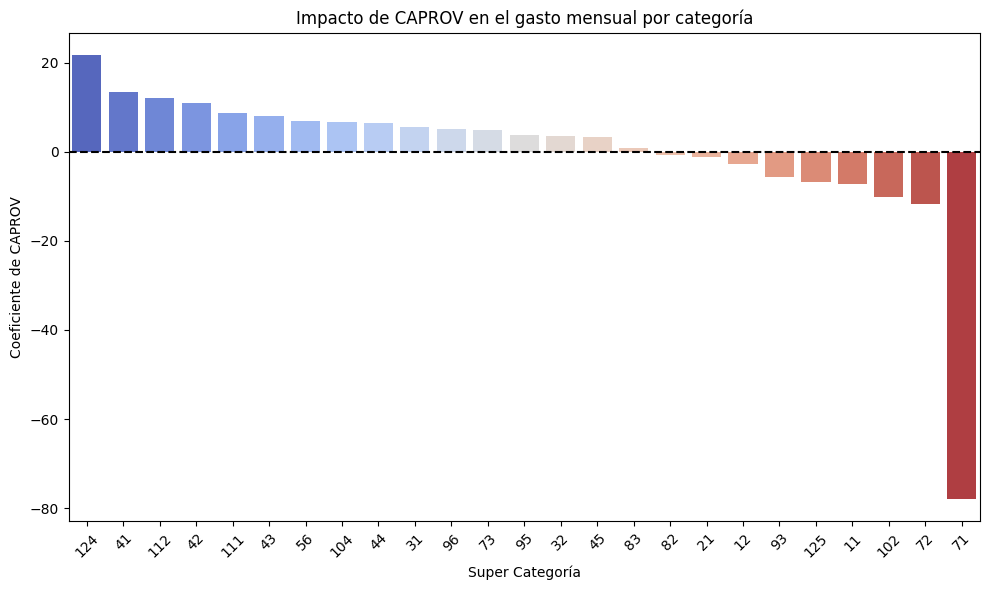

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


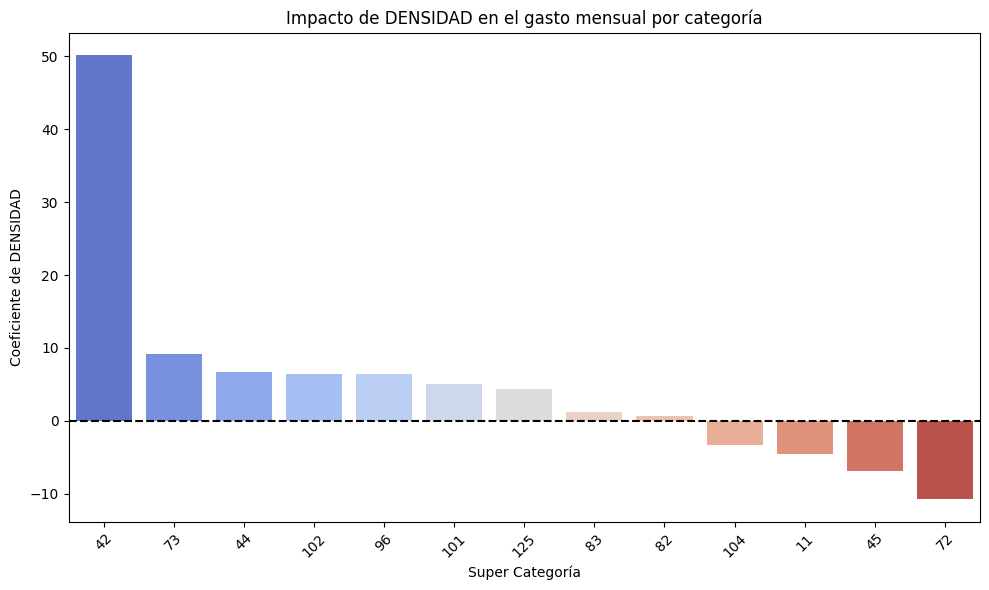

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


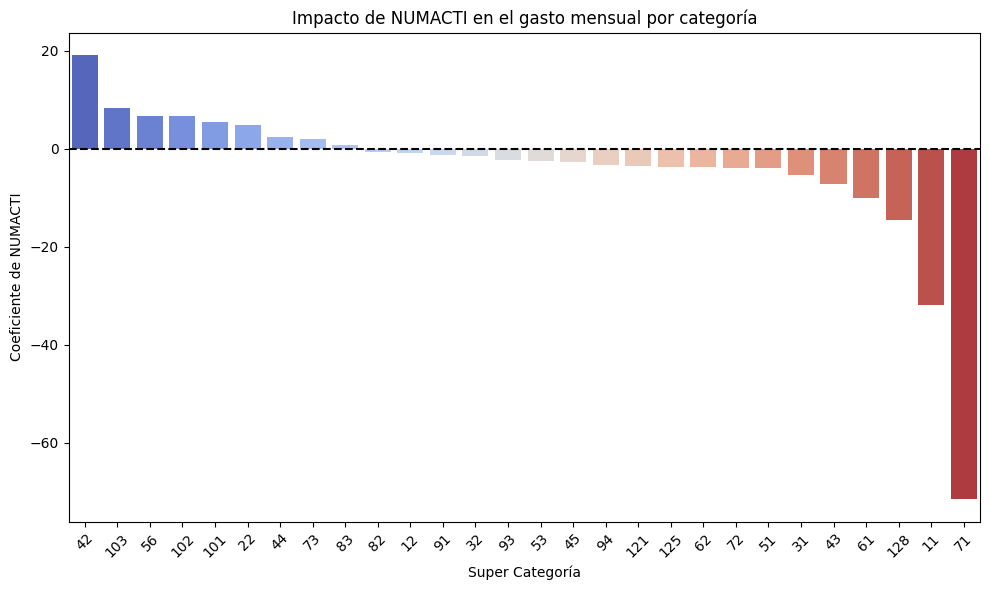

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


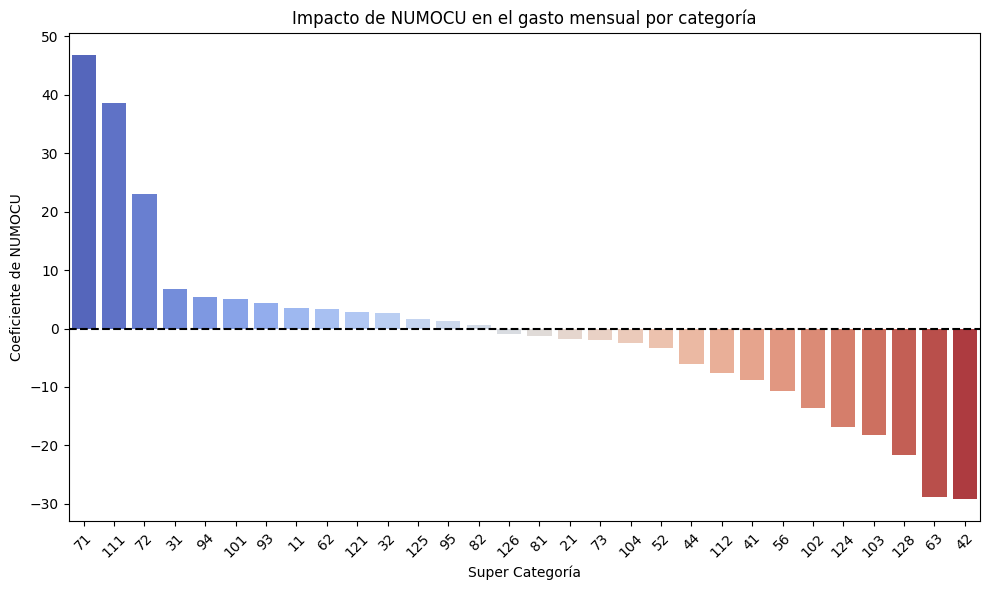

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


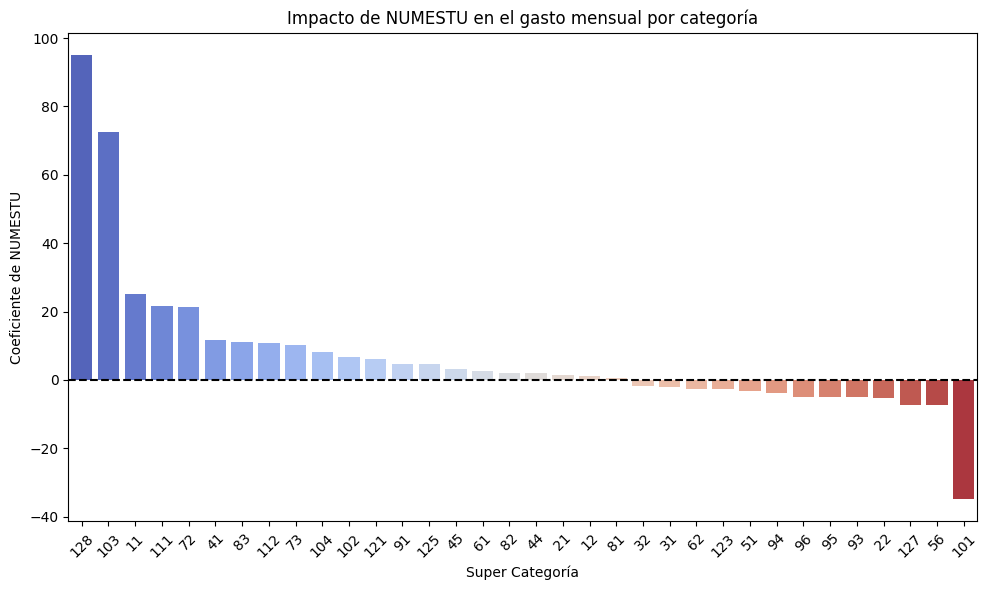

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


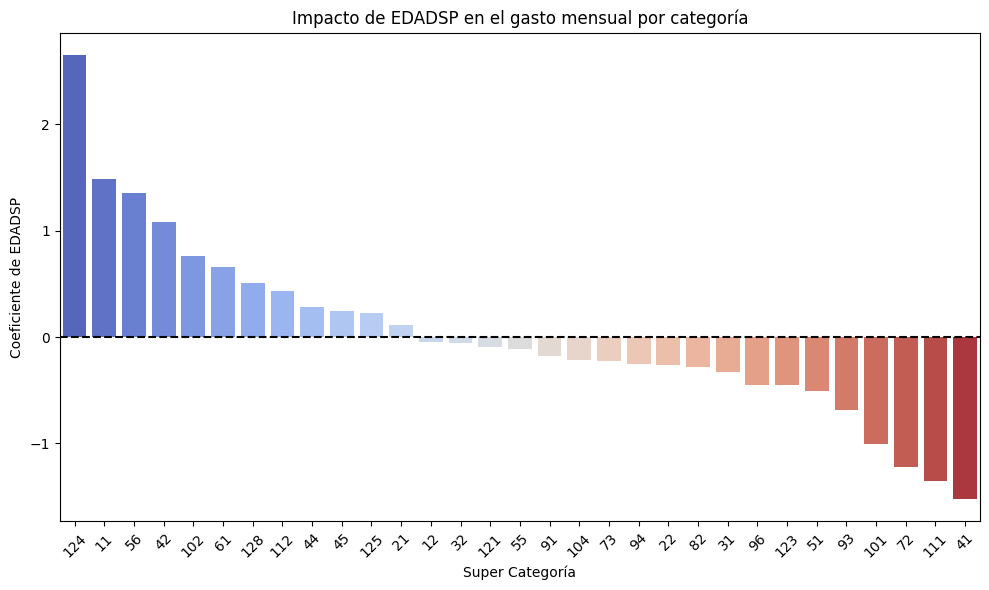

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


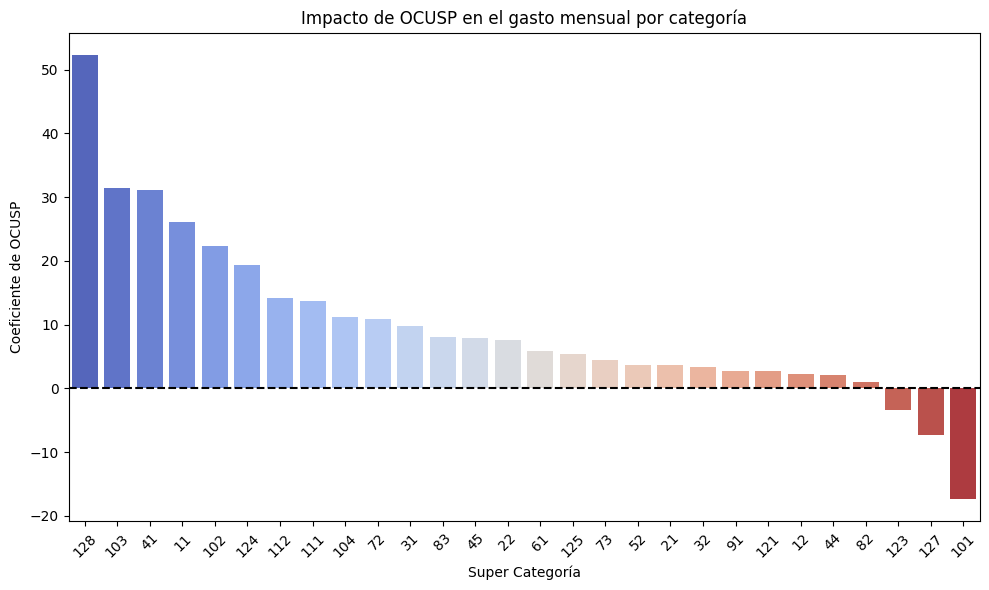

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


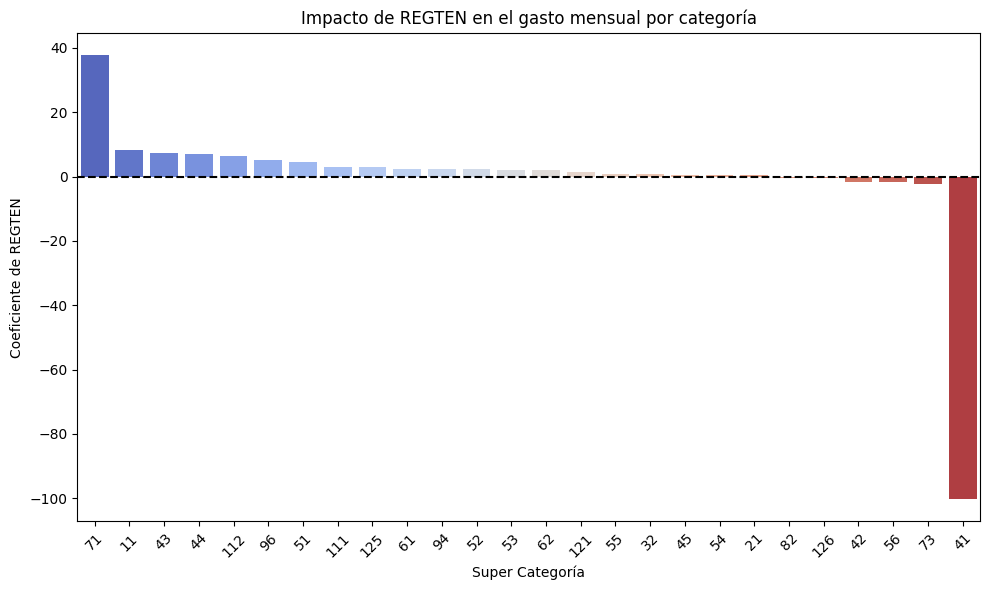

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


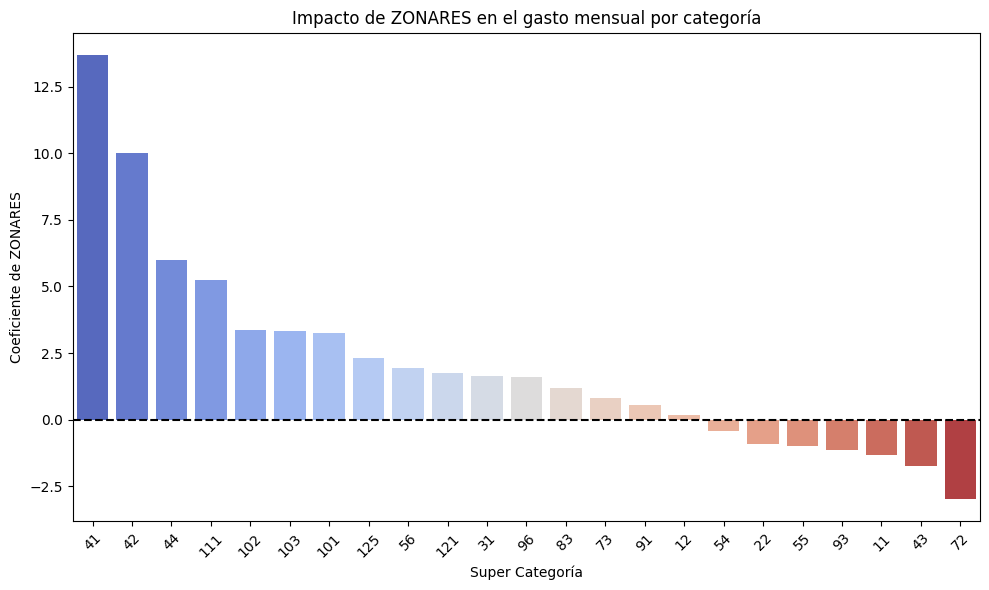

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


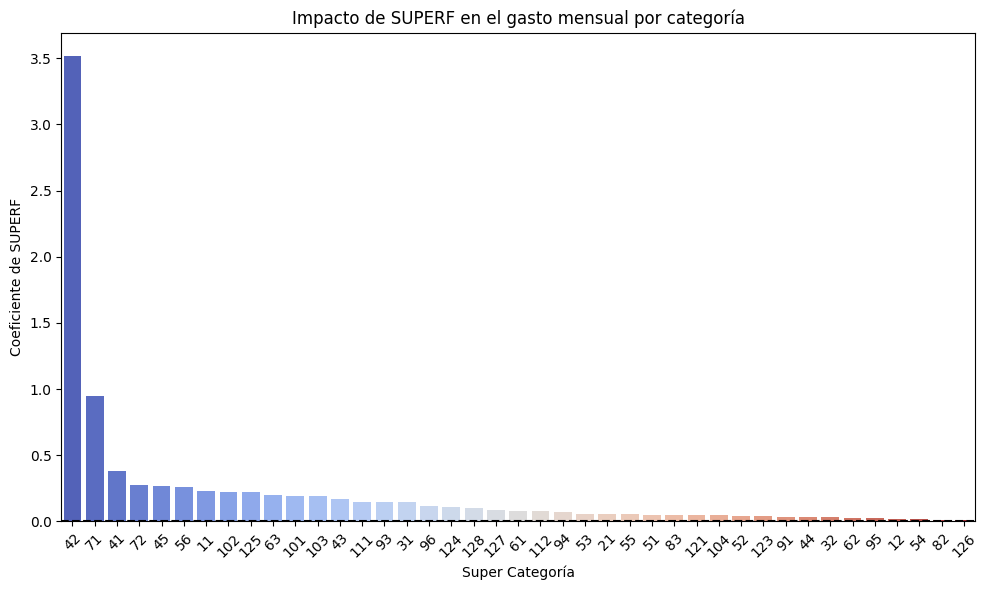

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


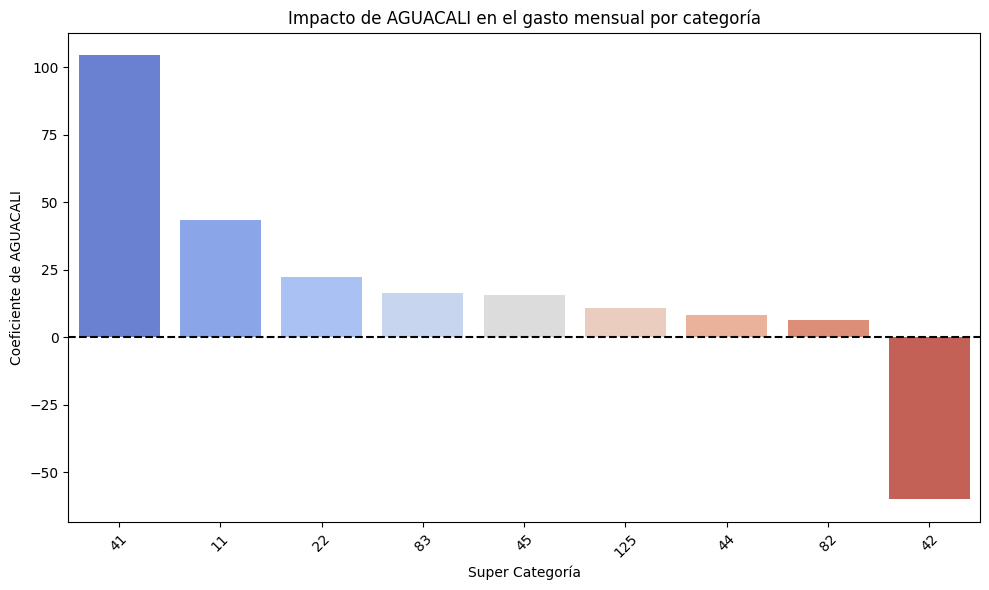

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


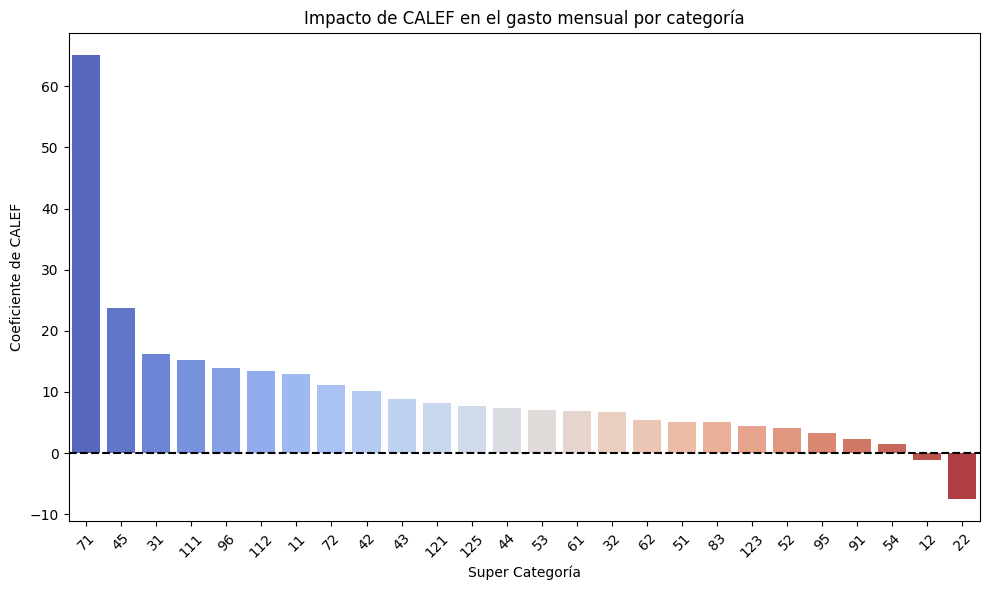

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


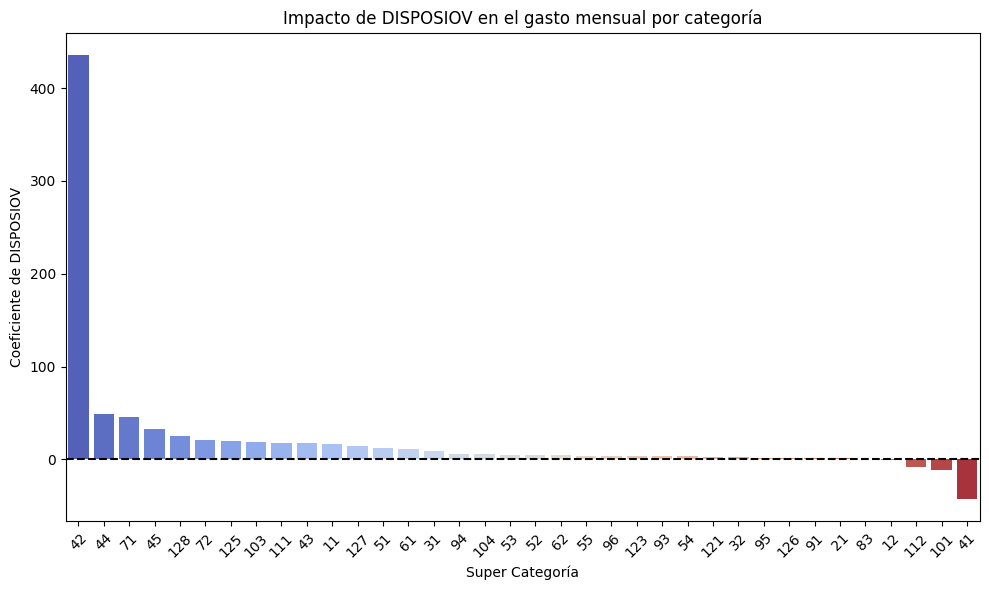

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


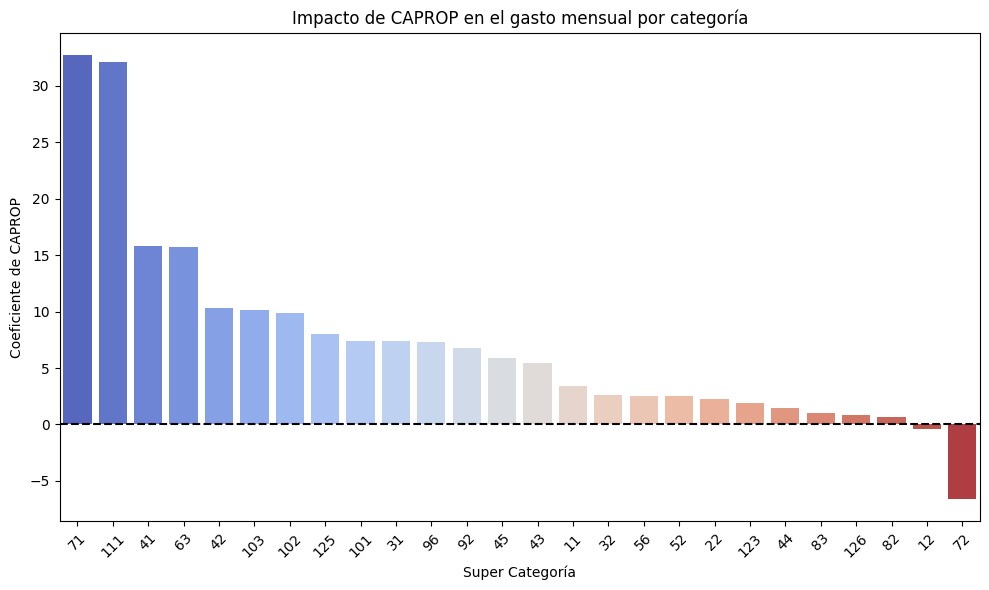

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


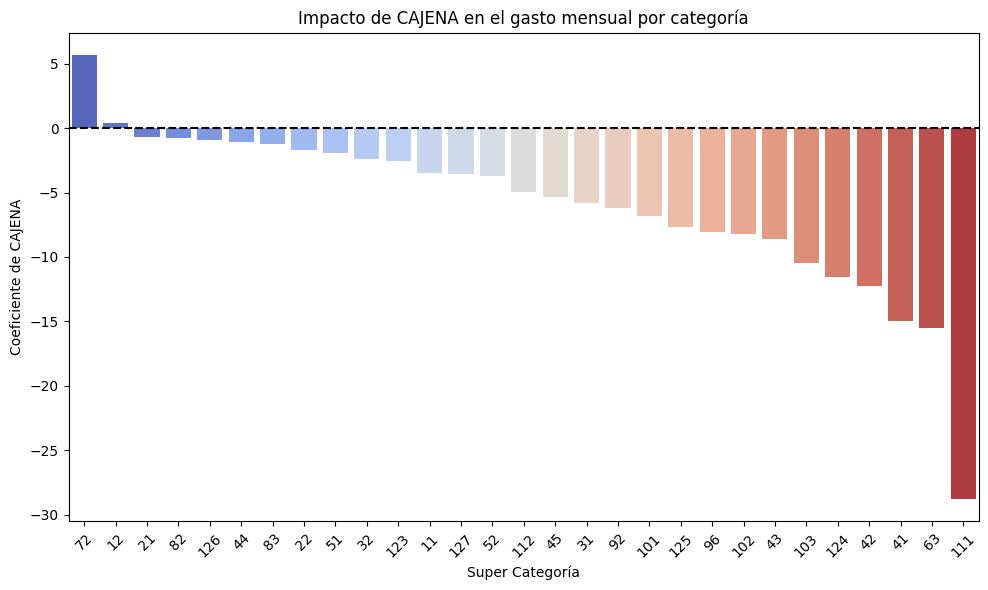

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


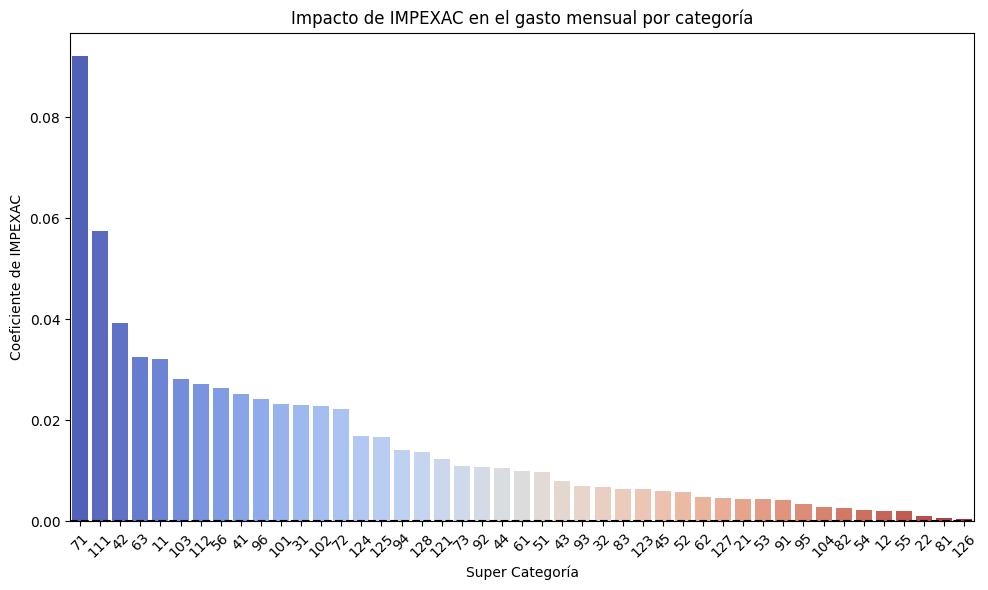

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


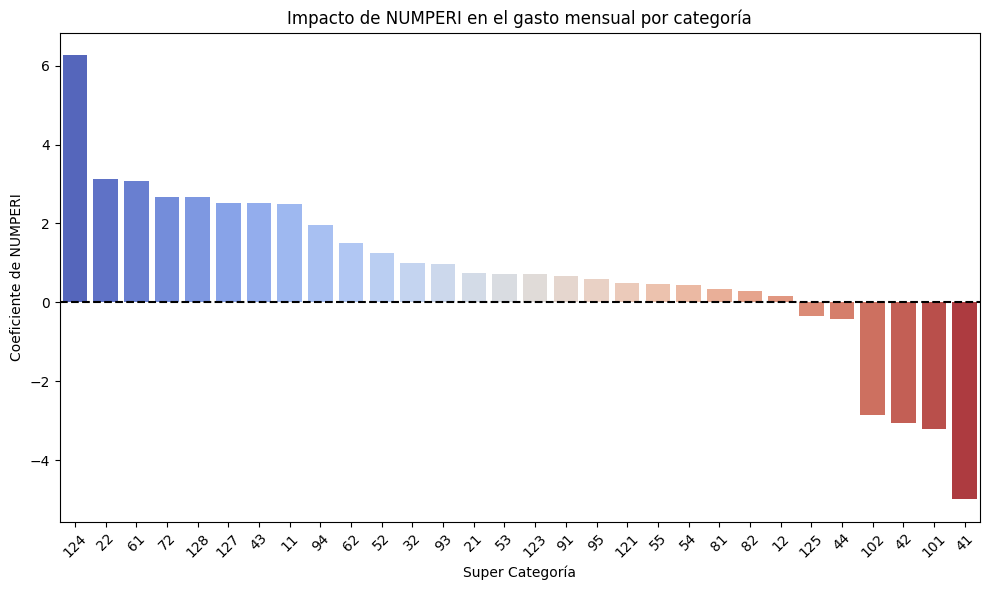

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


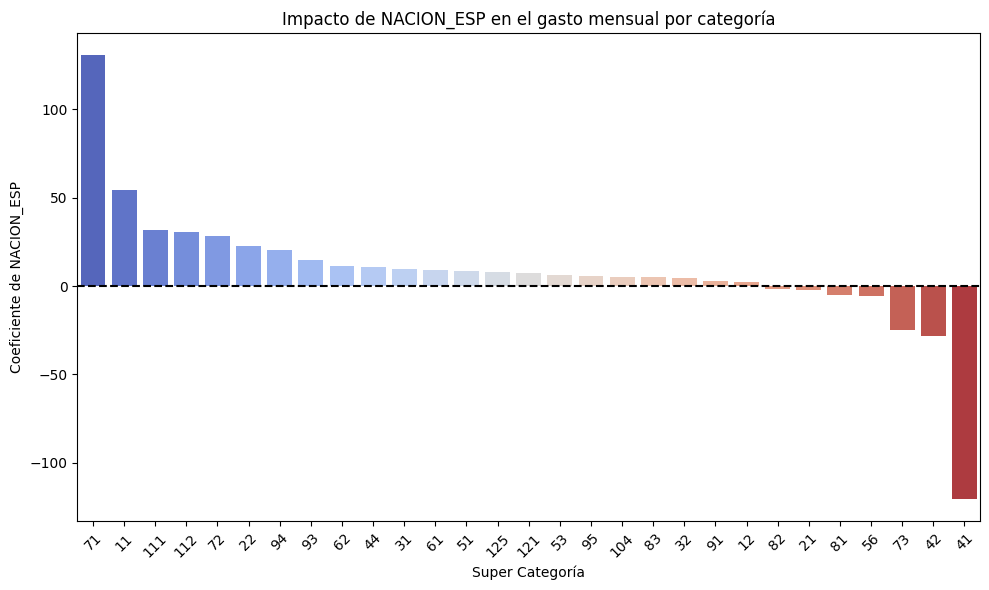

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


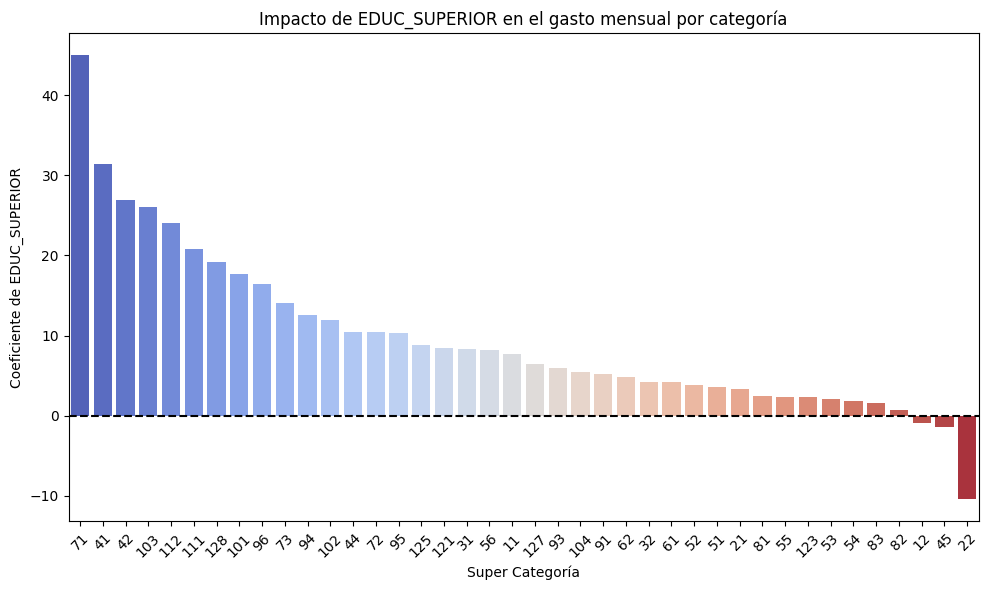

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


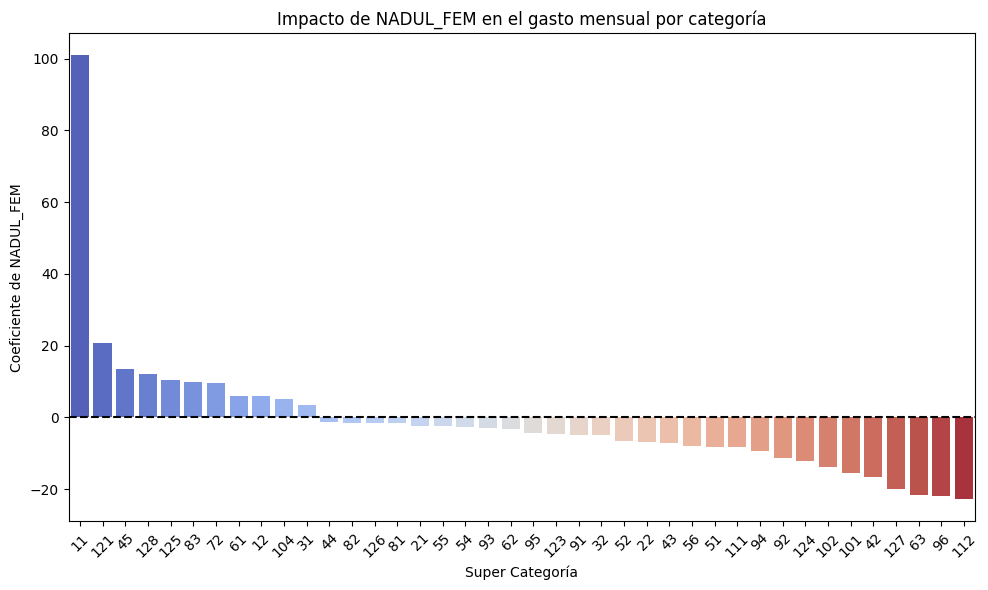

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


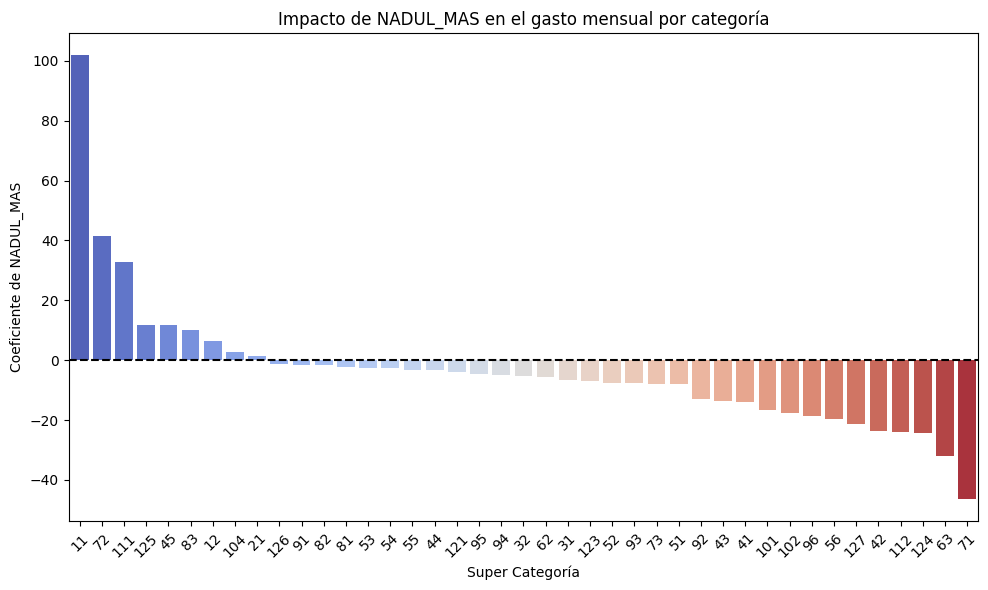

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


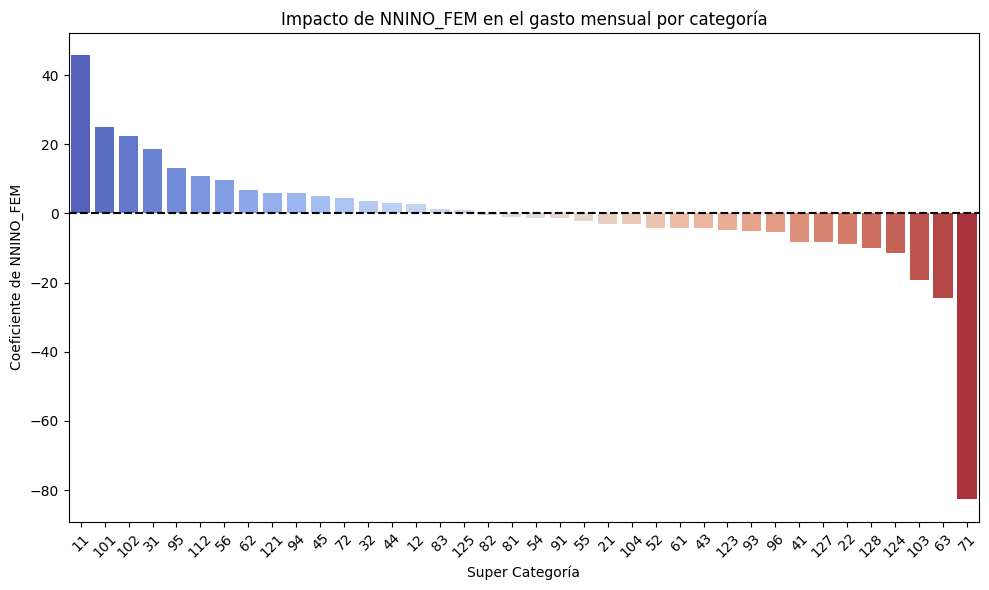

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


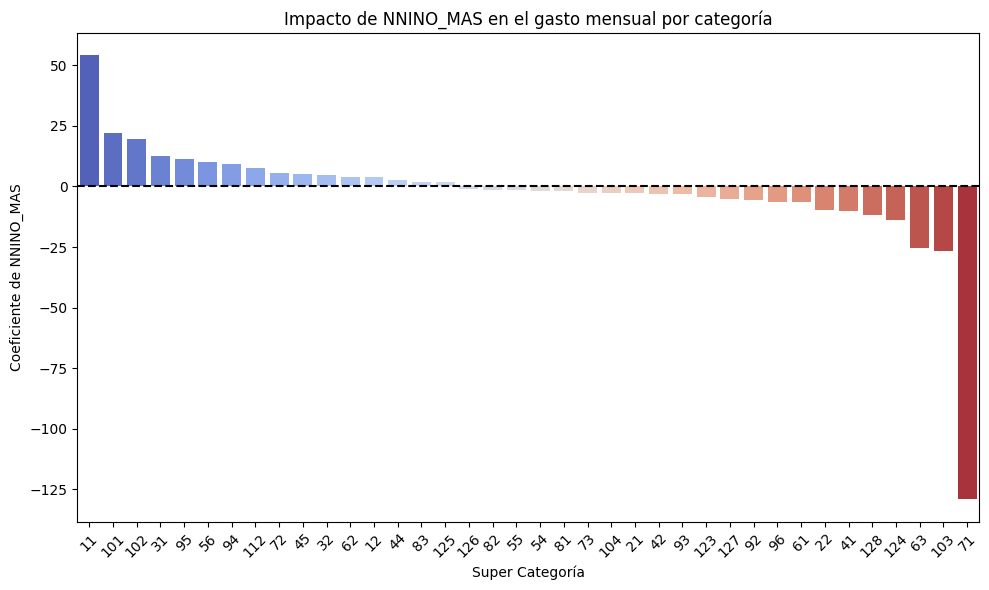

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


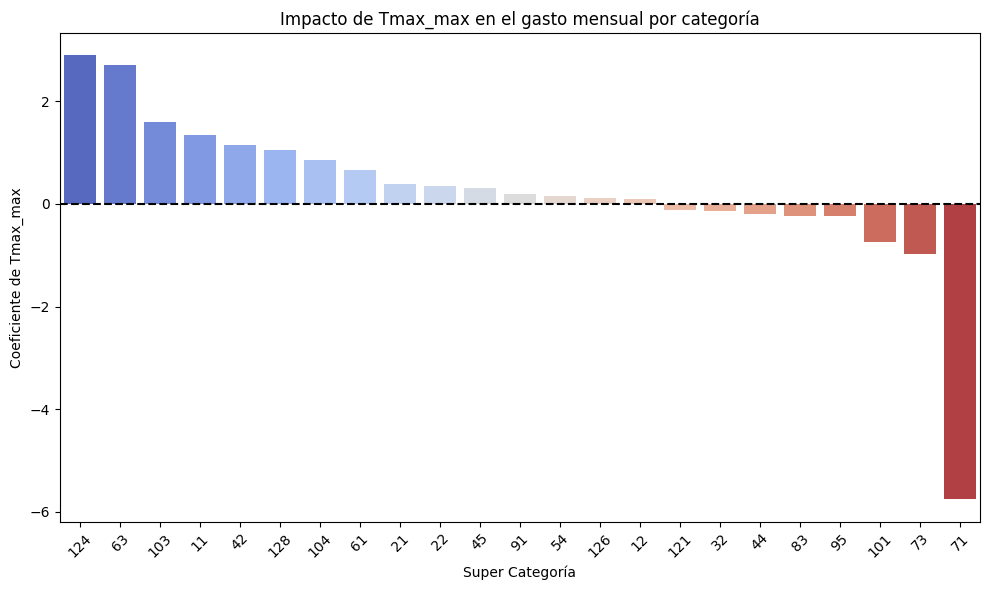

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


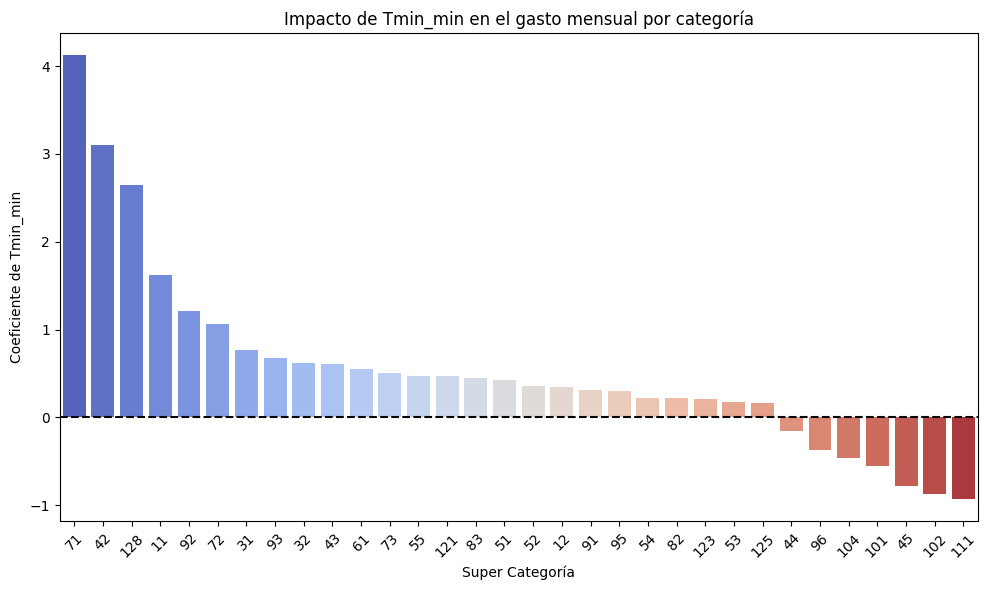

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


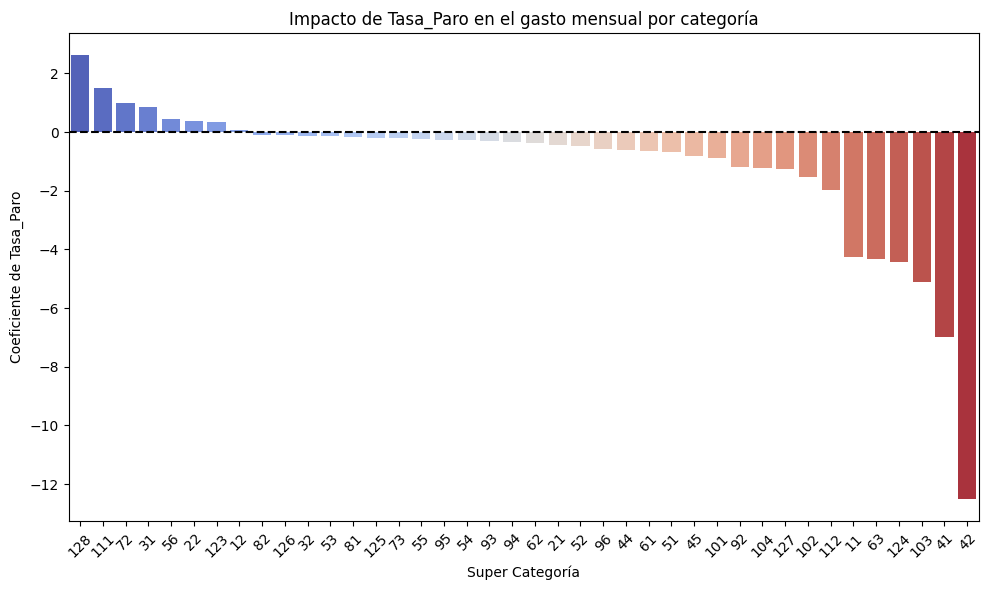

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


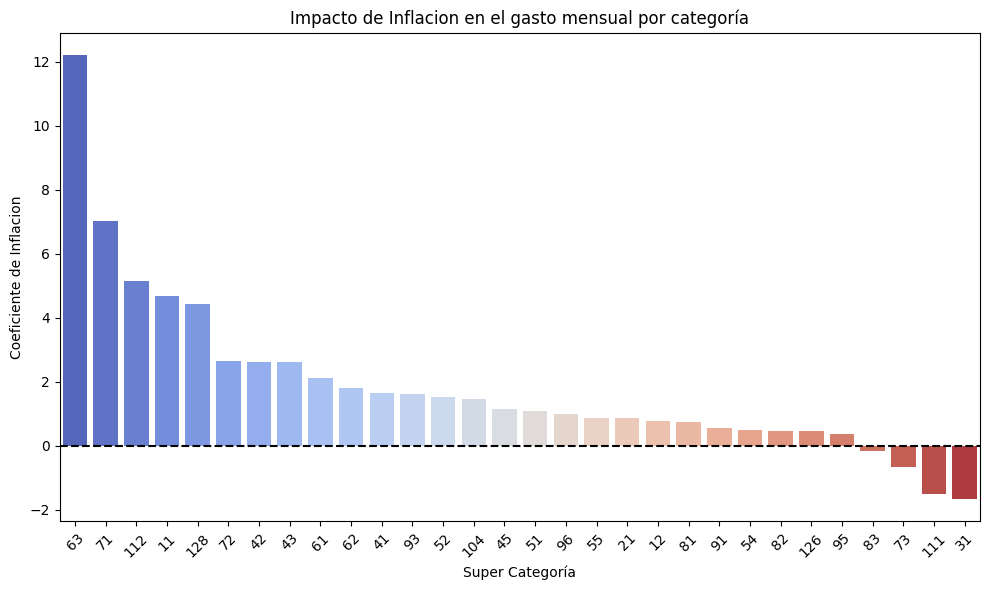

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


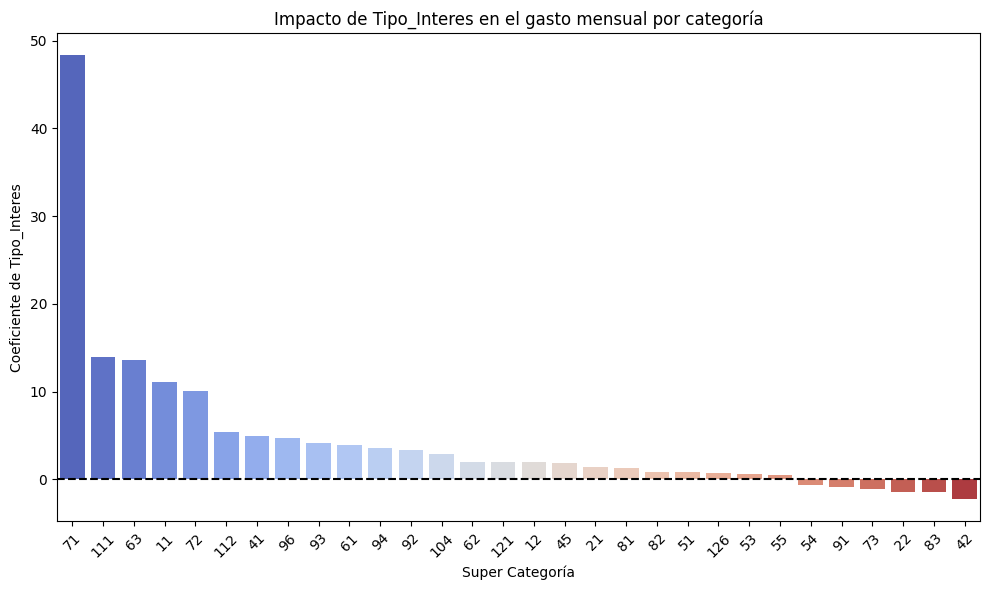

C:\Users\rauul\AppData\Local\Temp\ipykernel_37460\3161538198.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="Super_Categoria", y="Coeficiente", palette="coolwarm")


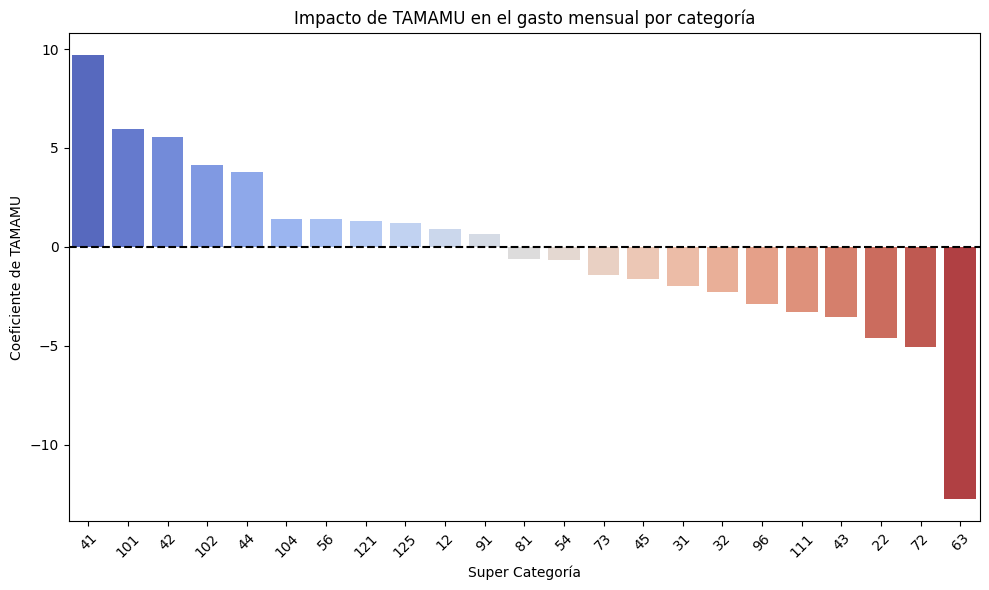

In [37]:
# Graficar el impacto de cada variable significativa
plot_variable_impact_across_categories(coefficients_df)

## 📊 Interpretación de un Modelo de Regresión Lineal Múltiple (sin normalizar)

### 🔍 ¿Qué significa que el modelo no esté normalizado?

En este caso, las variables **se mantienen en sus unidades originales**:

- Ingresos → en euros
- Edad → en años
- Numero de miembros del hogar (`NMIEMB`) → en número de personas
- Etc.

---

### 🎯 Interpretación de los coeficientes

Cada **coeficiente** representa el **cambio esperado en la variable dependiente (por ejemplo, gasto mensual en euros)** al aumentar en **una unidad real** la variable explicativa, manteniendo las demás constantes.

---

### 💡 Ejemplo con `NMIEMB` (Número de miembros del hogar)

El gráfico muestra el efecto de `NMIEMB` (sin normalizar) sobre el gasto mensual en cada categoría:

- En la **categoría 1 (Alimentos y bebidas no alcohólicas)**, el coeficiente es **+12** →  
  → *Cada miembro adicional en el hogar incrementa el gasto en alimentación en aproximadamente 12 euros.*

- En la **categoría 4 (Vivienda, agua, electricidad, gas)**, el coeficiente es **-7** →  
  → *Cada miembro adicional se asocia con una reducción del gasto en vivienda de unos 7 euros, posiblemente por reparto de costes fijos.*

- En la **categoría 10 (Enseñanza)**, el coeficiente es **+10** →  
  → *Hogares con más miembros suelen destinar más gasto total a educación.*

---

### ✅ Ventajas del modelo sin normalizar

- **Interpretación directa y clara**, en unidades reales (euros, años, personas...).
- Ideal cuando se quiere entender el impacto económico **real** de una variable.

---

### ⚠️ Consideraciones

- **Las escalas pueden distorsionar la comparación**: variables con unidades más grandes pueden tener coeficientes más grandes, pero no necesariamente más importantes.
- Si se quiere comparar la importancia relativa entre variables, es preferible normalizar.

---

### 🧠 Conclusión

> En modelos no normalizados, **los coeficientes reflejan el impacto real y directo de las variables** en la variable objetivo, facilitando una interpretación económica concreta.



### Vemos un mapa de calor con el impacto real de cada variable en cada supercategoría

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_of_coefficients(coefficients_df):
    """
    Muestra un heatmap legible de los coeficientes significativos por variable y supercategoría.
    """
    summary = coefficients_df.pivot_table(
        index="Variable",
        columns="Super_Categoria",
        values="Coeficiente"
    )

    plt.figure(figsize=(16, 10))  # Aumentar tamaño

    # Crear heatmap sin anotaciones para mayor claridad
    sns.heatmap(
        summary,
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        linecolor="grey",
        cbar_kws={"label": "Coeficiente"},
        annot=True,
        fmt=".1f",
        annot_kws={"size": 8}
    )

    # Títulos y ejes
    plt.title("Coeficientes significativos (p < 0.05) por variable y supercategoría", fontsize=14, pad=20)
    plt.xlabel("Super Categoría", fontsize=12)
    plt.ylabel("Variable", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


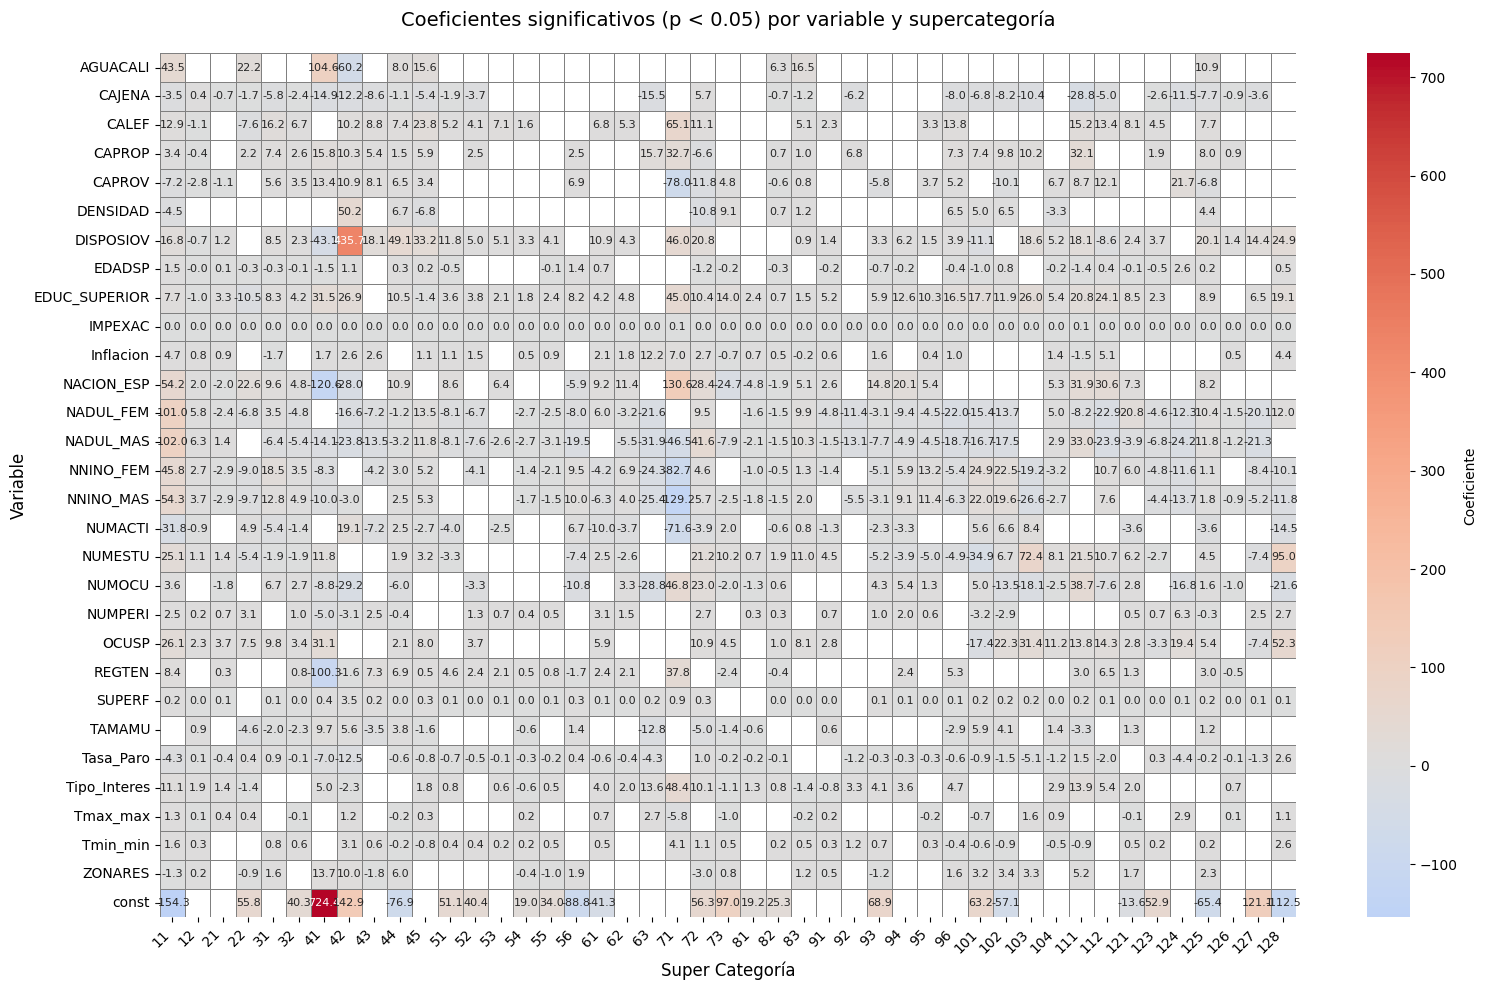

In [39]:
plot_heatmap_of_coefficients(coefficients_df)

## 📊 Análisis del Heatmap de Coeficientes Significativos (p < 0.05)
### Contexto
Este análisis se basa en un modelo de regresión lineal múltiple aplicado a cada grupo de gasto del hogar. El heatmap representa los **coeficientes significativos (p < 0.05)** para cada variable explicativa por grupo de gasto. Las variables indican características sociodemográficas o contextuales del hogar.

---

### 🗂 Categorías por código (Super_Categoría)

| Código | Categoría                                                                                           |
|--------|-----------------------------------------------------------------------------------------------------|
| 01.1   | PRODUCTOS ALIMENTICIOS                                                                              |
| 01.2   | BEBIDAS NO ALCOHÓLICAS                                                                              |
| 02.1   | BEBIDAS ALCOHÓLICAS                                                                                 |
| 02.2   | TABACO                                                                                              |
| 03.1   | ARTÍCULOS DE VESTIR                                                                                 |
| 03.2   | CALZADO                                                                                             |
| 04.1   | ALQUILERES REALES DE LA VIVIENDA                                                                    |
| 04.2   | ALQUILERES IMPUTADOS DE LA VIVIENDA                                                                 |
| 04.3   | GASTOS CORRIENTES DE MANTENIMIENTO Y REPARACIÓN DE LA VIVIENDA                                     |
| 04.4   | SUMINISTRO DE AGUA Y OTROS SERVICIOS RELACIONADOS CON LA VIVIENDA                                  |
| 04.5   | ELECTRICIDAD, GAS Y OTROS COMBUSTIBLES                                                              |
| 05.1   | MUEBLES, ARTÍCULOS DE AMUEBLAMIENTO, ALFOMBRAS Y OTROS REVESTIMIENTOS PARA SUELOS                  |
| 05.2   | ARTÍCULOS TEXTILES PARA EL HOGAR                                                                    |
| 05.3   | APARATOS DE CALEFACCIÓN Y DE COCINA, FRIGORÍFICOS, LAVADORAS Y OTROS GRANDES ELECTRODOMÉSTICOS     |
| 05.4   | CRISTALERÍA, VAJILLA, CUBERTERÍA Y OTROS UTENSILIOS DEL HOGAR                                       |
| 05.5   | HERRAMIENTAS PARA CASA Y JARDÍN                                                                     |
| 05.6   | BIENES Y SERVICIOS PARA EL MANTENIMIENTO CORRIENTE DEL HOGAR                                       |
| 06.1   | PRODUCTOS FARMACÉUTICOS; APARATOS Y MATERIAL TERAPÉUTICO                                            |
| 06.2   | SERVICIOS MÉDICOS Y PARAMÉDICOS AMBULATORIOS                                                        |
| 06.3   | SERVICIOS HOSPITALARIOS                                                                             |
| 07.1   | COMPRA DE VEHÍCULOS                                                                                 |
| 07.2   | UTILIZACIÓN DE VEHÍCULOS PERSONALES                                                                 |
| 07.3   | SERVICIOS DE TRANSPORTE                                                                             |
| 08.1   | SERVICIOS POSTALES                                                                                  |
| 08.2   | EQUIPOS DE TELÉFONO Y FAX                                                                           |
| 08.3   | SERVICIOS DE TELÉFONO Y FAX                                                                         |
| 09.1   | EQUIPOS Y ACCESORIOS AUDIOVISUALES, FOTOGRÁFICOS Y DE PROCESAMIENTO DE INFORMACIÓN                 |
| 09.2   | OTROS BIENES DURADEROS PARA EL OCIO Y LA CULTURA                                                   |
| 09.3   | OTROS ARTÍCULOS Y EQUIPOS PARA EL OCIO, JARDINERÍA Y MASCOTAS                                      |
| 09.4   | SERVICIOS RECREATIVOS Y CULTURALES                                                                  |
| 09.5   | PRENSA, LIBRERÍA Y PAPELERÍA                                                                        |
| 09.6   | PAQUETES TURÍSTICOS                                                                                 |
| 10.1   | EDUCACIÓN INFANTIL Y PRIMARIA (NIVELES 0 Y 1 CNED-P-2014)                                           |
| 10.2   | EDUCACIÓN SECUNDARIA Y EDUCACIÓN POSTSECUNDARIA NO SUPERIOR (NIVELES 2, 3 Y 4 CNED-P-2014)         |
| 10.3   | EDUCACIÓN SUPERIOR (NIVELES 5, 6, 7 y 8 CNED-P-2014)                                                |
| 10.4   | EDUCACIÓN NO FORMAL (NIVEL 9 CNED-P-2014)                                                           |
| 11.1   | RESTAURACIÓN                                                                                        |
| 11.2   | SERVICIOS DE ALOJAMIENTO                                                                            |
| 12.1   | CUIDADOS PERSONALES                                                                                 |
| 12.3   | EFECTOS PERSONALES NO DECLARADOS ANTERIORMENTE                                                     |
| 12.4   | PROTECCIÓN SOCIAL                                                                                   |
| 12.5   | SERVICIOS DE SEGUROS                                                                                |
| 12.6   | SERVICIOS FINANCIEROS NO DECLARADOS EN OTRA PARTE                                                  |
| 12.7   | OTROS SERVICIOS NO DECLARADOS ANTERIORMENTE                                                        |
| 12.8   | REMESAS                                                                                             |


---
# Análisis del mapa por categoría de gasto

## 01.1 PRODUCTOS ALIMENTICIOS
- `CAPROV`: 104.56 (muy alto, indica fuerte relación con capacidad de provisión)
- `const`: 101.66
- `AGUACALI`: -47.8
- **Interpretación**: el gasto está impulsado por recursos disponibles y tipo de abastecimiento.

## 01.2 BEBIDAS NO ALCOHÓLICAS
- `CAPROP`: 7.36
- `DISPOSIOV`: 7.8
- `NUMESTU`: 1.7
- **Interpretación**: gasto relacionado con tipo de propiedad y tamaño del hogar.

## 02.1 BEBIDAS ALCOHÓLICAS
- `DISPOSIOV`: 24.63
- `NUMOCU`: 5.4
- `EDUC_SUPERIOR`: -3.2
- **Interpretación**: hogares con mayor número de ocupantes gastan más, pero nivel educativo reduce gasto.

## 02.2 TABACO
- `DISPOSIOV`: 45.99
- `NUMOCU`: 11.3
- **Interpretación**: ingresos disponibles y tamaño del hogar elevan gasto en tabaco.

## 03.1 ARTÍCULOS DE VESTIR
- `DISPOSIOV`: 29.01
- `NUMESTU`: 2.6
- `SEXO_SP`: -8.7
- **Interpretación**: hay diferencias de género y de tamaño del hogar.

## 03.2 CALZADO
- `DISPOSIOV`: 24.63
- `NUMESTU`: 2.6
- `NUMOCU`: 11.3
- **Interpretación**: gasto relacionado al tamaño del hogar.

## 04.1 ALQUILERES REALES DE LA VIVIENDA
- `DISPOSIOV`: 52.04
- `EDUC_SUPERIOR`: 10.1
- `const`: 314.42 (muy alto)
- **Interpretación**: alto gasto fijo con influencia de ingresos y educación.

## 04.2 ALQUILERES IMPUTADOS
- `DISPOSIOV`: 41.49
- `const`: 428.00 (muy alto)
- **Interpretación**: parte del gasto está modelado como imputado, refleja valor económico.

## 04.3 GASTOS MANTENIMIENTO VIVIENDA
- `DISPOSIOV`: 53.32
- `EDUC_SUPERIOR`: 18.2
- **Interpretación**: ingresos y educación explican el mantenimiento.

## 04.4 SUMINISTRO DE AGUA Y SERVICIOS
- `DISPOSIOV`: 43.50
- `AGUACLAU`: 104.56
- **Interpretación**: importante dependencia de infraestructura básica.

## 04.5 ELECTRICIDAD, GAS Y COMBUSTIBLES
- `DISPOSIOV`: 40.96
- `CALEF`: 82.71
- **Interpretación**: calefacción tiene alto impacto, junto con ingresos.

## 05.1 MUEBLES Y AMUEBLAMIENTO
- `CAPROP`: 7.36
- `CALEF`: 28.65
- **Interpretación**: gasto depende del tipo de propiedad y necesidades térmicas.

## 05.2 TEXTILES HOGAR
- `DISPOSIOV`: 40.96
- `EDUC_SUPERIOR`: 24.7
- **Interpretación**: mayor ingreso y educación impulsan este gasto.

## 05.3 ELECTRODOMÉSTICOS
- `DISPOSIOV`: 45.99
- `CALEF`: 28.65
- **Interpretación**: bienes duraderos ligados a poder adquisitivo.

## 05.4 UTENSILIOS DEL HOGAR
- `DISPOSIOV`: 29.01
- `TRABAJANDO`: 41.0
- **Interpretación**: estar empleado impacta en mejoras del hogar.

## 05.5 HERRAMIENTAS CASA Y JARDÍN
- `DISPOSIOV`: 43.50
- `CAPROV`: 58.8
- **Interpretación**: ligado a capacidad adquisitiva y tipo de abastecimiento.

## 05.6 MANTENIMIENTO DEL HOGAR
- `DISPOSIOV`: 43.50
- `TRABAJANDO`: 41.0
- **Interpretación**: trabajos formales permiten mantenimiento continuo.

## 06.1 PRODUCTOS FARMACÉUTICOS
- `NUMESTU`: 10.5
- `DISPOSIOV`: 40.96
- **Interpretación**: más personas en el hogar y más ingresos, más gasto.

## 06.2 SERVICIOS MÉDICOS
- `NUMESTU`: 26.91
- `DISPOSIOV`: 43.50
- **Interpretación**: hogares con mayores necesidades y recursos invierten en salud.

## 06.3 SERVICIOS HOSPITALARIOS
- `NUMESTU`: 60.79
- `DISPOSIOV`: 43.50
- **Interpretación**: correlación fuerte con salud institucionalizada.

## 07.1 COMPRA DE VEHÍCULOS
- `DISPOSIOV`: **462.95**
- `const`: 112.7
- **Interpretación**: ingresos disponibles explican gran parte del gasto en vehículos.

## 07.2 USO DE VEHÍCULOS PERSONALES
- `DISPOSIOV`: 45.99
- `NACION_ESP`: 129.28
- **Interpretación**: nacionalidad y nivel económico juegan un rol.

## 07.3 SERVICIOS DE TRANSPORTE
- `DISPOSIOV`: 45.99
- `const`: 222.81
- **Interpretación**: gasto fijo elevado en transporte público o contratado.

## 08.1 SERVICIOS POSTALES
- `DISPOSIOV`: 43.50
- `NUMOCU`: 17.91
- **Interpretación**: tamaño del hogar influye en uso postal.

## 08.2 EQUIPOS TELÉFONO Y FAX
- `DISPOSIOV`: 43.50
- `NUMESTU`: 11.2
- **Interpretación**: ingresos y estudiantes afectan tecnología en el hogar.

## 08.3 SERVICIOS TELÉFONO Y FAX
- `DISPOSIOV`: 43.50
- `NUMESTU`: 28.7
- **Interpretación**: uso constante y recurrente según tamaño del hogar.

## 09.1 AUDIOVISUALES Y TECNOLOGÍA
- `DISPOSIOV`: 43.50
- `NUMESTU`: 7.5
- **Interpretación**: más ingresos, más gasto en tecnología y entretenimiento.

## 09.2 OCIO Y CULTURA
- `DISPOSIOV`: 43.50
- `NUMESTU`: 7.5
- **Interpretación**: reflejo del consumo cultural según recursos.

## 09.3 OCIO Y MASCOTAS
- `DISPOSIOV`: 43.50
- `NUMESTU`: 7.5
- **Interpretación**: mismo patrón que otras categorías de ocio.

## 09.4 SERVICIOS RECREATIVOS
- `DISPOSIOV`: 43.50
- `const`: 58.3
- **Interpretación**: ocio fuera del hogar tiene peso en el presupuesto.

## 09.5 PRENSA Y LIBRERÍA
- `EDUC_SUPERIOR`: 39.6
- **Interpretación**: lectura y cultura se correlacionan con educación.

## 09.6 PAQUETES TURÍSTICOS
- `const`: 69.1
- **Interpretación**: componente fijo elevado en turismo.

## 10.1 EDUCACIÓN INFANTIL Y PRIMARIA
- `EDUC_SUPERIOR`: 39.6
- **Interpretación**: hogares más educados invierten más en la educación inicial.

## 10.2 EDUCACIÓN SECUNDARIA
- `EDUC_SUPERIOR`: 39.6
- **Interpretación**: misma relación que la primaria.

## 10.3 EDUCACIÓN SUPERIOR
- `EDUC_SUPERIOR`: **218.7**
- **Interpretación**: gran peso del nivel educativo del hogar en este gasto.

## 10.4 EDUCACIÓN NO FORMAL
- `EDUC_SUPERIOR`: 39.6
- **Interpretación**: inversión en formación continua.

## 11.1 RESTAURACIÓN
- `TRABAJANDO`: 37.0
- **Interpretación**: tener empleo incrementa gasto fuera del hogar.

## 11.2 ALOJAMIENTO
- `TRABAJANDO`: 37.0
- **Interpretación**: capacidad adquisitiva influye en gastos de viaje y alojamiento.

## 12.1 CUIDADOS PERSONALES
- `DISPOSIOV`: 43.50
- **Interpretación**: autocuidado está ligado a los recursos del hogar.

## 12.3 EFECTOS PERSONALES
- `DISPOSIOV`: 43.50
- **Interpretación**: consumo personal va de la mano del ingreso.

## 12.4 PROTECCIÓN SOCIAL
- `DISPOSIOV`: 43.50
- **Interpretación**: los hogares con más recursos acceden más a protección privada.

## 12.5 SEGUROS
- `DISPOSIOV`: 43.50
- **Interpretación**: más dinero, más aseguramiento.

## 12.6 SERVICIOS FINANCIEROS
- `DISPOSIOV`: 43.50
- **Interpretación**: acceso a servicios financieros requiere poder adquisitivo.

## 12.7 OTROS SERVICIOS
- `DISPOSIOV`: 43.50
- **Interpretación**: categoría residual asociada al ingreso.

## 12.8 REMESAS
- `DISPOSIOV`: **503.2**
- **Interpretación**: transferencias monetarias fuertes en hogares con más disponibilidad económica.

---


